In [1]:
import numpy as np
import jplus
import get_3dhst as hst
from astropy.io import fits
import elgtools as elg
import MockJPLUS as mtools
import matplotlib.pyplot as plt
import Read_Mocks as read


plotsdir = 'plots/'

# Loading J-PLUS data
print 'Loading J-PLUS'
mag_type = 'gpsfMags'
gal_jplus = jplus.datasets.fetch_jplus_objects(mag_type=mag_type, overwrite=False, 
                                                 object_name="jplus_pz", nchunks=20, mag_limit=[16,24.],
                                                extra_where_conds='',db='dr1', allphotoz=True, upperlimparams=True)


#print 'Computing 3FM'
#dm_min = 0.0 # rough number, to be computed as a function using the actual trumpet plots for individual tiles.

#gal_jplus['dm'] = mtools.gen_3fm(gal_jplus['J0660'][:,0],  gal_jplus['rJAVA'][:,0], gal_jplus['gJAVA'][:,0], 
#                         Broad_NoLineName='gSDSS')

#gal_jplus['err_dm'] = mtools.gen_3fm_err(gal_jplus['J0660'][:,0], gal_jplus['J0660'][:,1], 
#                                         gal_jplus['rJAVA'][:,0], gal_jplus['rJAVA'][:,1], 
#                          gal_jplus['gJAVA'][:,0], gal_jplus['gJAVA'][:,1],Broad_NoLineName='gSDSS')

print 'setting redshift ranges of ELGs'
f_j0660 = jplus.datasets.fetch_jplus_filter('J0660') # Filter transmission curve

w_oii = 3727.0 # OII rest-frame
z_oii = elg.zline(w_oii, f_j0660.wave, f_j0660.throughput)

w_ha = 6563.0
z_ha = elg.zline(w_ha, f_j0660.wave, f_j0660.throughput)

w_hb = 4861.0
z_hb = elg.zline(w_hb, f_j0660.wave, f_j0660.throughput)
        
w_oiii = 5007.0
z_oiii = elg.zline(w_oiii, f_j0660.wave, f_j0660.throughput)

print z_oii, z_ha, z_hb, z_oiii


j-plus [INFO]: Fetching J-PLUS galaxies
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/jplus_jplus_pz_gpsfMags_dr1_dual_magmax24.0.h5


Loading J-PLUS
setting redshift ranges of ELGs


j-plus [INFO]: Fetching  J-PLUS filters


[0.7482142815072982, 0.7964311035074512] [-0.007223125525262806, 0.020158269506669296] [0.3403815320258589, 0.3773500766863342] [0.30129710948226485, 0.3371876817999342]


In [2]:
# Cross Match with SDSS Phot and add SDSS magnitudes to master, gal_jplus catalogue

AddSDSSPhot = True # This adds SDSS magnitudes to xmatches with gal_jplus, but then removes the original gal_jplus and replaces it with the xmatches
LoadSDSSxJPLUS = True # if False it will perform the cross match. Otherwise it reads a file

xmfile = 'jplus_sdssphot.data'
import pickle
if AddSDSSPhot:

    if LoadSDSSxJPLUS:
        print 'loading x-match'
        gal_jplus = pickle.load(open(xmfile))
        numf = len(gal_jplus['tile_id'])
        print 'Number of objects:%ld'%numf
    else:
        import deepdish as dp
        sdssfile = '/home/CEFCA/aaorsi/work/sdss/sdss_phot.h5'
        # Due to memory restrictions, the file is loaded by chunks

        print 'Loading SDSSPhot coordinates'
        sdss_coords = dp.io.load(sdssfile,'/coords')

        ngal0 = len(gal_jplus['tile_id'])

        print 'Cross-match of SDSSPhot with J-PLUS ...'
        d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],sdss_coords,max_distance=1e-3)
        m = ((d != np.inf))
        gal_jplus = jplus.tools.select_object(gal_jplus, m)    
        numf = len(gal_jplus['tile_id'])
        print 'xmatch catalogue contains %ld galaxies, %.2f of the input J-PLUS catalogue' % (numf, float(numf)/ngal0)

        print 'Adding SDSS filters...'

        sdssmags = ['u','g','r','i','z']

        del sdss_coords
        for mag in sdssmags:
            magname = '%sSDSS'%mag
            print magname
            datamag = dp.io.load(sdssfile,'/'+magname)
            gal_jplus[magname] = datamag[ind[m]]
            del datamag

        with open(xmfile,'wb') as outfile:
            pickle.dump(gal_jplus,outfile,protocol=pickle.HIGHEST_PROTOCOL)   
    
        

loading x-match
Number of objects:2397580


In [4]:
# This takes long.



%matplotlib inline
suff = 'SDSSxxx'
gal = gal_jplus
import matplotlib.gridspec as gsc


if suff == 'SDSS': # check cross-match by comparing rJAVA to rSDSS
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    plt.rc('font', family='STIXGeneral')

    gs = gsc.GridSpec(2,1)
    gs.update(hspace=0.2)
    
    xr = [19.01,22.49]
    yr = [-0.3,0.3]
    ax = plt.subplot(gs[0])
    nm = 50
    marr   = np.linspace(xr[0],xr[1],nm)
    mb     = marr[1] - marr[0]
    ddm    = np.zeros([nm,3])
    dem    = np.zeros([nm,3])
    deltam = gal['rJAVA'][:,0] - gal['rSDSS'][:,0]
    ratio  = gal['rJAVA'][:,1]/gal['rSDSS'][:,1]
    mg     = gal['rSDSS'][:,0]
    counts, ybins, xbins, image = ax.hist2d(mg,deltam,
                                    bins=100, cmap=plt.cm.Greys, normed=LogNorm(), cmin=0.01, label='SDSS contaminants', 
                                    alpha=0.9,range=(xr,yr))
    
    for i in range(nm):
        sel = (mg > marr[i]-mb/2.) & (mg <= marr[i]+mb/2.)
        dd_i  = deltam[sel]
        err_i = ratio[sel]
        
        if len(dd_i) > 0:
            ddm[i,0] = np.percentile(dd_i,50)
            ddm[i,1] = np.percentile(dd_i,20)
            ddm[i,2] = np.percentile(dd_i,80)
        if len(err_i) > 0:
            dem[i,0] = np.percentile(err_i,50)
            dem[i,1] = np.percentile(err_i,20)
            dem[i,2] = np.percentile(err_i,80)
        
        
    ax.plot(xr,[0,0],'--k,')
    
    ax.fill_between(marr, ddm[:,1],ddm[:,2],facecolor='RoyalBlue',alpha=0.2)
    ax.plot(marr,ddm[:,0],'-',color='RoyalBlue',linewidth=1)
    ax.set_ylim(yr)
    ax.set_xlim(xr)
    
    ax.set_ylabel(r'$rJAVA - rSDSS$',fontsize=15)
    ax.set_xticklabels([])

    ax = plt.subplot(gs[1])
    
    yl = [.5,1.79]
    
    counts, ybins, xbins, image = ax.hist2d(mg,ratio,
                                    bins=100, cmap=plt.cm.Greys, normed=LogNorm(), cmin=0.01, label='SDSS contaminants', 
                                    alpha=0.9,range=(xr,yl))

    ax.plot(xr,[1,1],'--k,')
    ax.set_ylim(yl)
    ax.set_xlim(xr)
    ax.fill_between(marr, dem[:,1],dem[:,2],facecolor='RoyalBlue',alpha=0.2)
    ax.plot(marr,dem[:,0],'-',color='RoyalBlue',linewidth=1)

    ax.set_ylabel(r'$\sigma_{rJAVA}/\sigma_{rSDSS}$',fontsize=15)
    ax.set_xlabel(r'$r{\rm SDSS}$',fontsize=15)
    
    plt.show()

    
    mg     = gal['J0660'][:,0]
    nm     = 20
    marr   = np.linspace(xr[0],xr[1],nm)
    mb     = marr[1] - marr[0]

    alltiles = np.unique(gal['tile_id'])
    ntiles = len(alltiles)
    
    plt.figure('ph_errors')#,figsize=(7,7))
    gs = gsc.GridSpec(3,1)
    gs.update(hspace=0.0)
    ax = plt.subplot(gs[0:2])
    yyr = [0.01,15]
    
    snr = 1./gal['J0660'][:,1]
    snr_rj = 1./gal['rJAVA'][:,1]
    snr_rs = 1./gal['rSDSS'][:,1]
    snr_gs = 1./gal['gSDSS'][:,1]
    
    counts, ybins, xbins, image = ax.hist2d(mg,snr,
                                    bins=100, cmap=plt.cm.Greys, normed=LogNorm(), cmin=0.01, label='SDSS contaminants', 
                                    alpha=1.0,range=(xr,yyr))
       
    
    dsnr    = np.zeros([nm,5])
    frac_sn = np.zeros([nm,ntiles])
    sn_limit = 5.0
    for i in range(nm):
        sel = (mg > marr[i]-mb/2.) & (mg <= marr[i]+mb/2.)
        dd_i  = snr[sel]
        
        if len(dd_i) > 0:
            dsnr[i,0] = np.percentile(dd_i,50)
            dsnr[i,1] = np.percentile(dd_i,10)
            dsnr[i,2] = np.percentile(dd_i,20)
            dsnr[i,3] = np.percentile(dd_i,80)
            dsnr[i,4] = np.percentile(dd_i,90)
        
               
    ax.plot(xr,[sn_limit,sn_limit],'--k')
  #  ax.set_xlabel(r'$r{\rm SDSS}$',fontsize=15)
    ax.set_ylabel(r'${\rm SNR}_{J0660}$',fontsize=15)
    ax.set_xlim(xr)
    ax.set_xticklabels([])
    
    ax.fill_between(marr, dsnr[:,1],dsnr[:,4],facecolor='RoyalBlue',alpha=0.2)
    ax.fill_between(marr, dsnr[:,2],dsnr[:,3],facecolor='RoyalBlue',alpha=0.2)
    
    ax = plt.subplot(gs[2])
    
    for it in range(ntiles):
        tt = alltiles[it] 
        print it,
        for i in range(nm):
            sel = (mg > marr[i]-mb/2.) & (mg <= marr[i]+mb/2.)
            selmg = sel & (np.asarray(gal['tile_id']) == tt)
            
            sel2 = (selmg & (snr > sn_limit) & (snr_rj > sn_limit) & 
                   (snr_rs > sn_limit) & (snr_gs > sn_limit))
        
            if len(mg[selmg]) >0:    
                frac_sn[i,it] = (len(snr[sel2]) + 0.0)/(len(mg[selmg]))
        
 #       if it < 10:
 #           print frac_sn[:,it]

    
    
    for i in range(nm):
        ax.plot(marr,frac_sn[:,i],'-k',linewidth=.25)
        
    ax.set_ylim([0,1.09])
    ax.set_xlabel(r'$J0660$',fontsize=15)
    ax.set_ylabel(r'$f({\rm SNR}> 5)$',fontsize=15)
    ax.set_xlim(xr)

        

snrfile = 'snr.data'
snrdata = {'marr': marr, 'frac_sn':frac_sn,'alltiles':alltiles}
with open(snrfile,'wb') as outfile:
        pickle.dump(snrdata,outfile,protocol=pickle.HIGHEST_PROTOCOL)  

    
    
    

In [5]:
# Compute sigma curves for each tile
%matplotlib inline
ComputeSigmas = False
import matplotlib

suff ='SDSS'

import pickle
import matplotlib.gridspec as gsc
if ComputeSigmas:
    
    reload(elg)
    alltiles = np.random.permutation(np.unique(gal_jplus['tile_id']))
    ntiles = len(alltiles)
    print 'Number of tiles:%d'%ntiles
    sigma_tiles = []

    npanels = 5

    gs = gsc.GridSpec(npanels,1)
    gs.update(wspace=0.0, hspace=0.0, top=2)
    gal_jplus['ids'] = np.arange(0,len(gal_jplus['tile_id']))
    gal_jplus['elgcand'] = np.zeros(len(gal_jplus['tile_id']))
    gal_jplus['dm_j0660'] = np.zeros(len(gal_jplus['tile_id']))
    gal_jplus['dm_j0660_err'] = np.zeros(len(gal_jplus['tile_id']))
    nc = 0
    for i in range(ntiles):
    
    #for i in range(20):
        if i < npanels:
            ax = plt.subplot(gs[i])
        
        idcand,dm, dm_err, sfunc = elg.continuum_curve(gal_jplus, alltiles[i], BroadLineName = 'r'+suff,
                 BroadNoLineName='g'+suff, Plot=ax if i < npanels else False,
                 sigma_threshold = 2.0)
        sigma_tiles.append(sfunc)
        
        gal_jplus['elgcand'][idcand] = 1
        gal_jplus['dm_j0660'][idcand] = dm
        gal_jplus['dm_j0660_err'][idcand] = dm_err
        if i == npanels:
            ax.set_xlabel(r'$r%s$'%suff, fontsize=25)
        if i == 2:
            ax.set_ylabel(r'$C^{r,g}-J0660$', fontsize=25)
        #plt.title('TileID: %d'%alltiles[i],fontsize=15)
        nc += len(idcand)
        

        #Save file with sigma curves

        sigma_dict = {'sfunc': sigma_tiles, 'tiles':alltiles}
        sigmafile = 'sigma_curves.data'

        with open(sigmafile,'wb') as outfile:
            pickle.dump(sigma_dict,outfile,protocol=pickle.HIGHEST_PROTOCOL)  



    elg_cand = jplus.tools.select_object(gal_jplus,gal_jplus['elgcand'] == 1)
    print 'saving candidate list...'
    
    with open('elg_cand.data', 'wb') as outfile:
        pickle.dump(elg_cand, outfile, protocol=pickle.HIGHEST_PROTOCOL)
else:
    elg_cand = pickle.load(open('elg_cand.data'))

print 'Number of ELG candidates: %d'%len(elg_cand['tile_id'])



Number of ELG candidates: 233508


NameError: name 'sigma_tiles' is not defined

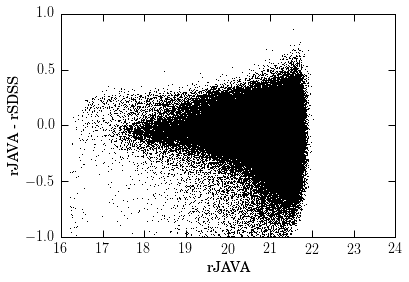

['mask_flags_iJAVA', 'dm_j0660', 'J0861', 'flags_aper3_worstpsf_J0378', 'fwhm', 'cstar', 'flags_aper3_worstpsf_J0515', 'mag_auto_r', 'mask_flags_J0515', 'single_detect_J0395', 'uJAVA', 'dm', 'single_detect_zJAVA', 'flags_aper3_gauss_J0515', 'gJAVA', 'norm_wmap_val_J0378', 'J0378', 'norm_wmap_val_rJAVA', 'single_detect_J0515', 'flags_aper3_gauss_iJAVA', 'flags_aper3_worstpsf_J0660', 'flag_J0430', 'rJAVA', 'flag_uJAVA', 'flags_aper3_worstpsf_J0861', 'elgcand', 'mask_flags_J0660', 'J0515', 'flags_aper3_worstpsf_J0410', 'mask_flags_gJAVA', 'mask_flags_J0861', 'filename', 'single_detect_gJAVA', 'norm_wmap_val_iJAVA', 'flags_aper3_gauss_J0660', 'single_detect_uJAVA', 'err_dm', 'mask_flags_uJAVA', 'norm_wmap_val_J0515', 'flags_aper3_gauss_J0861', 'zSDSS', 'kron_rad', 'XY_IMAGE', 'mask_flags_J0378', 'flag_J0410', 'ids', 'dm_j0660_err', 'single_detect_J0430', 'flags_aper3_worstpsf_J0395', 'flags_aper3_gauss_zJAVA', 'flag_J0395', 'flags_aper3_gauss_uJAVA', 'single_detect_iJAVA', 'mask_flags_J039

In [6]:
%matplotlib inline

if suff == 'SDSS': # check cross-match by comparing rJAVA to rSDSS
    import matplotlib.pyplot as plt

    plt.plot(elg_cand['rJAVA'][:,0],elg_cand['rJAVA'][:,0] - elg_cand['rSDSS'][:,0],'k,')
    plt.ylim([-1,1])
    plt.xlim([16,24])
    plt.xlabel('rJAVA')
    plt.ylabel('rJAVA - rSDSS')

    plt.show()

    print elg_cand.keys()


In [7]:

# Choose which base catalogue to use when constructing the dataset
dc = elg_cand
suff = 'SDSS'

dm, fline, fcont = mtools.gen_3fm(dc['J0660'][:,0],  
                    dc['r'+suff][:,0], dc['g'+suff][:,0], 
                    Broad_NoLineName='g'+suff)

mask = ((dc['dm_j0660'] > 0.4) & # a minimum EW limit -- not sure what this corresponds to
        (dc['r'+suff][:,0] > 20) &  # remove most of H-alpha contaminants
        (dc['mask_flags_J0660'] == 0) & # no artifacts is J0660 photometry
        (dc['mask_flags_rJAVA'] == 0) &
        (dc['single_detect_J0660'] != 0) & # Objects are detected in both rJAVA and J0660
        (1./dc['J0660'][:,1] > 5) &    # SNR of J0660 is above 5
         (1./dc['r'+suff][:,1] > 5) &  # SNR of SDSS r-band is above 5
        (1./dc['rJAVA'][:,1] > 5)     # also SNR of rJAVA is above 5
         )

dcat = jplus.tools.select_object(dc, mask)
dcat['F_j0660'] = fline[mask]
dcat['F_cont_j0660'] = fcont[mask]
print 'Total number of J-PLUS objects for cross-matches: %d'%len(dcat['tile_id'])


Total number of J-PLUS objects for cross-matches: 84442


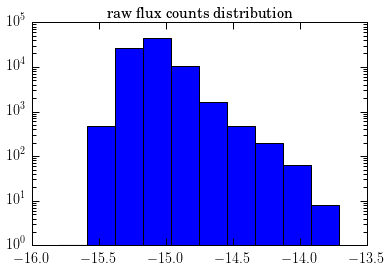

In [8]:
plt.hist(np.log10(np.asarray(dcat['F_j0660'])))
plt.yscale('log', nonposy='clip')
plt.title('raw flux counts distribution')



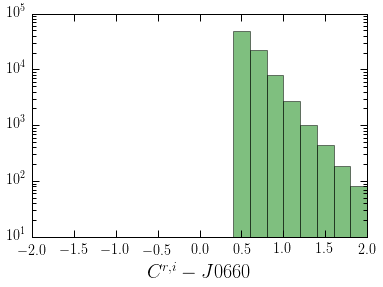

In [9]:
plt.hist(dcat['dm_j0660'], bins=20, color='green', alpha=0.5,range=[-2,2])


plt.xlabel(r'$C^{r,i} - J0660$',fontsize=20)
plt.xlim([-2,2])
plt.legend()
plt.yscale('log', nonposy='clip')



In [10]:
print 'Loading 3D-HST and DEEP2'
# Loading 3D-HST and DEEP2 DR4 data

hstdata = hst.select_3DHST_z(0,5)#,LineName='Ha_flux',LineMin=0.001)
nhst = len(hstdata['ra'])
hst_coords = np.zeros([nhst,2])

for i in range(nhst):
    hst_coords[i,:] = [hstdata['ra'][i],hstdata['dec'][i]]
hstdata['coords'] = hst_coords

deep2_data = '/home/CEFCA/aaorsi/work/elg_jplus/spec/deep2/dr4/zcat.deep2.dr4.fits'
deep2 = fits.open(deep2_data)[1].data


# XMatch with 3DHST
print 'xmatch with 3DHST'
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],hstdata['coords'],max_distance=3e-3)
m = ((d != np.inf))

jhst0 = jplus.tools.select_object(dcat, m)
jhst0['z_spec'] = hstdata['z'][ind[m]]

elg_hst =  (
            (((jhst0['z_spec'] > z_ha[0])   & (jhst0['z_spec'] < z_ha[1]))   |
           ((jhst0['z_spec'] > z_hb[0])   & (jhst0['z_spec'] < z_hb[1]))   |
           ((jhst0['z_spec'] > z_oiii[0]) & (jhst0['z_spec'] < z_oiii[1])) |
           ((jhst0['z_spec'] > z_oii[0])  & (jhst0['z_spec'] < z_oii[1]))))

jhst = jplus.tools.select_object(jhst0, elg_hst)
nhst = len(jhst['z_spec'])
jhst['idd'] = np.arange(nhst)


# xmatch with DEEP2
print 'xmatch with DEEP2'
d2mask = ((deep2['ZQUALITY'] > 2) &  # Select only Deep2 objects with good quality Redshifts
        (deep2['Z'] <= z_ha[1]) |
           ((deep2['Z'] >= z_hb[0])   &   (deep2['Z'] <= z_hb[1]))   |
           ((deep2['Z'] >= z_oiii[0]) &   (deep2['Z'] <= z_oiii[1])) |
           ((deep2['Z'] >= z_oii[0])  &   (deep2['Z'] <= z_oii[1])))
          
          
ndeep2 = len(deep2['RA'][d2mask])
dcoords = np.asarray([[deep2['RA'][d2mask][i], deep2['DEC'][d2mask][i]] for i in range(ndeep2)])
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],dcoords,max_distance=3e-3)
m = ((d != np.inf))

jdeep2 = jplus.tools.select_object(dcat, m )
jdeep2['z_spec'] = deep2['Z'][d2mask][ind[m]]
ndeep2 = len(jdeep2['z_spec'])  
#jdeep2['idd'] = np.arange(ndeep2)
print jdeep2['z_spec']
print jhst['z_spec']
print 'Done loading data!'

Loading 3D-HST and DEEP2
xmatch with 3DHST
xmatch with DEEP2
[0.3687895  0.34784138 0.36932802 0.78144133 0.36167777 0.7519522 ]
[]
Done loading data!


Reading and performing cross-match with ALHAMBRA objects
['F830W', 'F814W', 'F799W', 'F644W', 'F892W', 'F954W', 'F582W', 'zphoto', 'F427W', 'F675W', 'F551W', 'F768W', 'F365W', 'F706W', 'F458W', 'cstar', 'F489W', 'F861W', 'F923W', 'coords', 'F613W', 'F396W', 'F737W', 'F520W']
Cross match between Alhambra and J-PLUS results in 108 objects
14


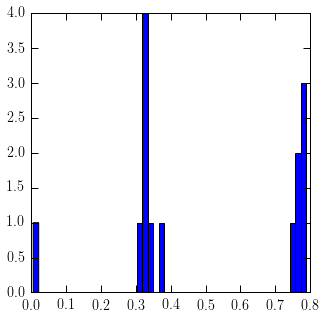

In [11]:
print 'Reading and performing cross-match with ALHAMBRA objects'
import deepdish as dd
AlhambraFile = '/home/CEFCA/aaorsi/work/alhambra/Alhambra.hdf5'

alh = dd.io.load(AlhambraFile)
print alh.keys()


alh_d,alh_ind = jplus.tools.crossmatch_angular(dcat['coords'],alh['coords'],max_distance=3e-4)
alh_m = ((alh_d != np.inf))

j_alh = jplus.tools.select_object(dcat, alh_m)
print 'Cross match between Alhambra and J-PLUS results in %ld objects' % len(j_alh['tile_id'])
j_alh['z_spec'] = alh['zphoto'][alh_ind[alh_m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  (
            (((j_alh['z_spec'] > z_ha[0])   & (j_alh['z_spec'] < z_ha[1]))   |
           ((j_alh['z_spec'] > z_hb[0])   & (j_alh['z_spec'] < z_hb[1]))   |
           ((j_alh['z_spec'] > z_oiii[0]) & (j_alh['z_spec'] < z_oiii[1])) |
           ((j_alh['z_spec'] > z_oii[0])  & (j_alh['z_spec'] < z_oii[1]))))


plt.hist(j_alh['z_spec'][mask_elgs], bins=50)
nalh = len(j_alh['z_spec'][mask_elgs])

j_alhambra = jplus.tools.select_object(j_alh, mask_elgs)

print nalh


j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_galaxies_aperMags_magmax21.0.h5


Cross-match of SDSS phot with J-PLUS ...
xmatch catalogue contains 2893 galaxies
70 SDSS ELGs, 2823 interlopers


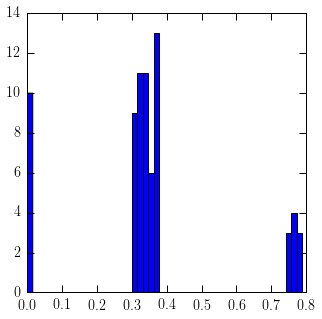

In [12]:
# Loading SDSS data

gal_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="galaxies")

print 'Cross-match of SDSS phot with J-PLUS ...'
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],gal_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))

j_spec = jplus.tools.select_object(dcat, m)

        
print 'xmatch catalogue contains %ld galaxies' % len(j_spec['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
j_spec['rSDSS'] = gal_sdss_spec['rSDSS'][ind[m]]
j_spec['iSDSS'] = gal_sdss_spec['iSDSS'][ind[m]]
j_spec['uSDSS'] = gal_sdss_spec['uSDSS'][ind[m]]
j_spec['gSDSS'] = gal_sdss_spec['gSDSS'][ind[m]]
j_spec['zSDSS'] = gal_sdss_spec['zSDSS'][ind[m]]
j_spec['z_spec'] = gal_sdss_spec['zspec'][ind[m]]

plt.rcParams['figure.figsize'] = 5, 5

mask_elgs =  (
            (((j_spec['z_spec'] > z_ha[0])   & (j_spec['z_spec'] < z_ha[1]))   |
           ((j_spec['z_spec'] > z_hb[0])   & (j_spec['z_spec'] < z_hb[1]))   |
           ((j_spec['z_spec'] > z_oiii[0]) & (j_spec['z_spec'] < z_oiii[1])) |
           ((j_spec['z_spec'] > z_oii[0])  & (j_spec['z_spec'] < z_oii[1]))))


plt.hist(j_spec['z_spec'][mask_elgs], bins=50)
nsdss = len(j_spec['z_spec'][mask_elgs])

j_sdss = jplus.tools.select_object(j_spec, mask_elgs)

j_sdss_interlopers = jplus.tools.select_object(j_spec, ~mask_elgs) #interlopers, i.e. outside ELG redshifts

nsdss_inter = len(j_sdss_interlopers['z_spec'])


print '%d SDSS ELGs, %d interlopers' % (nsdss, nsdss_inter)


In [13]:
# Interlopers, stars and QSOs:

stars_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="stars")

qso_sdss_spec = jplus.datasets.fetch_sdss_objects(mag_type="aperMags",overwrite=False,mag_limit=[16,21], extinction=False,
                                                          clean = True, nchunks = 5, spectroscopic=True, 
                                                    casjobs=True, object_name="qso")


print 'Cross-match of SDSS QSOs with ELG cands ...'
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],qso_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))

q_spec = jplus.tools.select_object(dcat, m)

        
print 'xmatch catalogue contains %ld galaxies' % len(j_spec['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
q_spec['rSDSS'] = qso_sdss_spec['rSDSS'][ind[m]]
q_spec['iSDSS'] = qso_sdss_spec['iSDSS'][ind[m]]
q_spec['uSDSS'] = qso_sdss_spec['uSDSS'][ind[m]]
q_spec['gSDSS'] = qso_sdss_spec['gSDSS'][ind[m]]
q_spec['zSDSS'] = qso_sdss_spec['zSDSS'][ind[m]]
q_spec['z_spec'] = qso_sdss_spec['zspec'][ind[m]]

nqso = len(q_spec['z_spec'])


print 'Cross-match of SDSS stars with ELG cands ...'
d,ind = jplus.tools.crossmatch_angular(dcat['coords'],stars_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))

s_spec = jplus.tools.select_object(dcat, m)

        
print 'xmatch catalogue contains %ld galaxies' % len(j_spec['tile_id'])
        #jplus['in_sdss'] = m
        # Adding SDSS magnitudes
s_spec['rSDSS'] = stars_sdss_spec['rSDSS'][ind[m]]
s_spec['iSDSS'] = stars_sdss_spec['iSDSS'][ind[m]]
s_spec['uSDSS'] = stars_sdss_spec['uSDSS'][ind[m]]
s_spec['gSDSS'] = stars_sdss_spec['gSDSS'][ind[m]]
s_spec['zSDSS'] = stars_sdss_spec['zSDSS'][ind[m]]
s_spec['z_spec'] = np.zeros(len(ind[m])) #stars

nstars = len(s_spec['z_spec'])

print 'ELG cands include %d stars and %d known QSOs' % (nstars, nqso)


ncontaminants = nstars + nqso + nsdss_inter




j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_stars_aperMags_magmax21.0.h5
j-plus [INFO]: Fetching SDSS objects
j-plus [INFO]:    Loading /home/CEFCA/aaorsi/photoz/jplus_data/sdss_qso_aperMags_magmax21.0.h5


Cross-match of SDSS QSOs with ELG cands ...
xmatch catalogue contains 2893 galaxies
Cross-match of SDSS stars with ELG cands ...
xmatch catalogue contains 2893 galaxies
ELG cands include 199 stars and 760 known QSOs


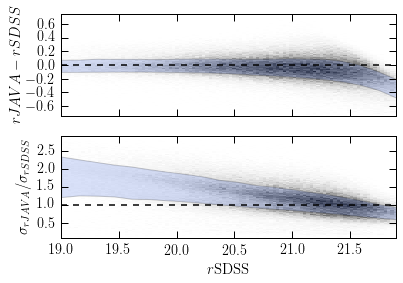

['mask_flags_iJAVA', 'dm_j0660', 'J0861', 'flags_aper3_worstpsf_J0378', 'fwhm', 'cstar', 'flags_aper3_worstpsf_J0515', 'mag_auto_r', 'mask_flags_J0515', 'single_detect_J0395', 'uJAVA', 'dm', 'single_detect_zJAVA', 'flags_aper3_gauss_J0515', 'gJAVA', 'norm_wmap_val_J0378', 'J0378', 'norm_wmap_val_rJAVA', 'single_detect_J0515', 'flags_aper3_gauss_iJAVA', 'flags_aper3_worstpsf_J0660', 'flag_J0430', 'rJAVA', 'flag_uJAVA', 'flags_aper3_worstpsf_J0861', 'elgcand', 'mask_flags_J0660', 'J0515', 'flags_aper3_worstpsf_J0410', 'mask_flags_gJAVA', 'mask_flags_J0861', 'filename', 'single_detect_gJAVA', 'norm_wmap_val_iJAVA', 'flags_aper3_gauss_J0660', 'single_detect_uJAVA', 'err_dm', 'mask_flags_uJAVA', 'norm_wmap_val_J0515', 'flags_aper3_gauss_J0861', 'zSDSS', 'kron_rad', 'XY_IMAGE', 'mask_flags_J0378', 'flag_J0410', 'ids', 'dm_j0660_err', 'single_detect_J0430', 'flags_aper3_worstpsf_J0395', 'flags_aper3_gauss_zJAVA', 'flag_J0395', 'flags_aper3_gauss_uJAVA', 'single_detect_iJAVA', 'mask_flags_J039

In [14]:
%matplotlib inline

if suff == 'SDSS': # check cross-match by comparing rJAVA to rSDSS
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    plt.rc('font', family='STIXGeneral')

    gs = gsc.GridSpec(2,1)
    gs.update(hspace=0.2)
    
    xr = [19,21.9]
    
    ax = plt.subplot(gs[0])
    nm = 20
    marr   = np.linspace(xr[0],xr[1],nm)
    mb = marr[1] - marr[0]
    ddm    = np.zeros([nm,3])
    dem    = np.zeros([nm,3])
    deltam = elg_cand['rJAVA'][:,0] - elg_cand['rSDSS'][:,0]
    ratio  = elg_cand['rJAVA'][:,1]/elg_cand['rSDSS'][:,1]
    mg = elg_cand['rSDSS'][:,0]
    counts, ybins, xbins, image = ax.hist2d(mg,deltam,
                                    bins=100, cmap=plt.cm.Greys, normed=LogNorm(), cmin=0.01, label='SDSS contaminants', 
                                    alpha=0.9,range=(xr,[-.75,.749]))
    
    for i in range(nm):
        sel = (mg > marr[i]-mb/2.) & (mg <= marr[i]+mb/2.)
        dd_i  = deltam[sel]
        err_i = ratio[sel]
        
        if len(dd_i) > 0:
            ddm[i,0] = np.percentile(dd_i,50)
            ddm[i,1] = np.percentile(dd_i,20)
            ddm[i,2] = np.percentile(dd_i,80)
        if len(err_i) > 0:
            dem[i,0] = np.percentile(err_i,50)
            dem[i,1] = np.percentile(err_i,20)
            dem[i,2] = np.percentile(err_i,80)
        
        
        
    
    
    ax.plot(xr,[0,0],'--k,')
    
    ax.fill_between(marr, ddm[:,1],ddm[:,2],facecolor='RoyalBlue',alpha=0.2)
    #ax.plot(marr,ddm[:,0],'.-',color='RoyalBlue',linewidth=3)
    ax.set_ylim([-.75,.749])
    ax.set_xlim(xr)
    
    ax.set_ylabel(r'$rJAVA - rSDSS$',fontsize=15)
    ax.set_xticklabels([])

    ax = plt.subplot(gs[1])
    
    yl = [.1,2.9]
    
    counts, ybins, xbins, image = ax.hist2d(mg,ratio,
                                    bins=100, cmap=plt.cm.Greys, normed=LogNorm(), cmin=0.01, label='SDSS contaminants', 
                                    alpha=0.9,range=(xr,yl))

    ax.plot(xr,[1,1],'--k,')
    ax.set_ylim(yl)
    ax.set_xlim(xr)
    ax.fill_between(marr, dem[:,1],dem[:,2],facecolor='RoyalBlue',alpha=0.2)
   # ax.plot(marr,dem[:,0],'.-',color='RoyalBlue',linewidth=3)

    ax.set_ylabel(r'$\sigma_{rJAVA}/\sigma_{rSDSS}$',fontsize=15)
    ax.set_xlabel(r'$r{\rm SDSS}$',fontsize=15)
    
    plt.show()

    print elg_cand.keys()


In [15]:
# Loading Lightcone galaxies
nCone = 512
lcone = []
reload(read)
#Mockpath = '/home/CEFCA/aaorsi/work/JPLUS_Mock/new/Lines/'
Mockpath = '/home/CEFCA/aaorsi/work/JPLUS_Mock/new_0918/'
namelc   = 'LightCone_SA_0_'

print 'reading Lightcone...'
for i in range(nCone): #nCone):
    nameIn = '%s%s%d' % (Mockpath, namelc, i)
    ilc = read.readmock_chunk_PythonCut(nameIn, zspace = True)
    lcone.append(ilc[0])
    
dcone = np.concatenate(lcone)

reading Lightcone...


In [16]:
dcone[0]['ObsMagDust']
print dcone.dtype
names_filters = ['uJAVA' , 'J0378', 'J0395', 'J0410', 'J0430', 'gSDSS',
                         'J0515', 'rSDSS', 'J0660', 'iSDSS', 'J0861', 'zSDSS']

nf = len(names_filters)
mockgals = {}

for _i in range(nf):
    fname = names_filters[_i]
    mockgals[fname] = dcone['ObsMagDust'][_i,:]

mockgals['redshift'] = dcone['redshift']

print mockgals.keys()





[('Type', '<i4'), ('FOFMvir', '<f4'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('sfr', '<f4'), ('sfr_inst', '<f4'), ('BulgeMass', '<f4'), ('DiskMass', '<f4'), ('Mvir', '<f4'), ('redshift', '<f4'), ('MetalColdGas', '<f4'), ('ColdGas', '<f4'), ('BlackHoleMass', '<f4'), ('ObsMagDust', '<f4', (12,))]
['uJAVA', 'rSDSS', 'iSDSS', 'J0861', 'gSDSS', 'J0395', 'redshift', 'zSDSS', 'J0378', 'J0430', 'J0660', 'J0410', 'J0515']


In [17]:
# Loading synthetic photometry from various surveys
import learn_elgs as learn
reload(learn)
tfout = '/home/CEFCA/aaorsi/work/elg_jplus/trainspec.dat'
vvds = '/home/CEFCA/aaorsi/work/elg_jplus/trainspec_vvds.dat'
alleboss, photo_eboss = learn.Load_Synthetic_Sample(tfout,overwrite=False, survey='eBOSS', get_sdss_filters=True,
                                                  sdssxjplus=False)

allvvds, photo_vvds = learn.Load_Synthetic_Sample(vvds,overwrite=False, survey='VVDS', get_sdss_filters=True,
                                                  sdssxjplus=False,field=['F02_UDEEP','F02_DEEP'])


allspec = alleboss + allvvds

photo_spec = {}
nvvds = len(photo_vvds['uJAVA'])
for key in photo_eboss.keys():
    photo_spec[key] = photo_eboss[key].tolist()
    for j in range(nvvds):
        photo_spec[key].append(photo_vvds[key][j])
    photo_spec[key] = np.asarray(photo_spec[key])



j-plus [INFO]:    Downloading eBOSS ELG composite spectrum from https://data.sdss.org/sas/dr13/eboss/elg/composite/v1_0/eBOSS_ELG_composite.fits


j-plus [INFO]:    Downloading eBOSS ELG composite spectrum from https://data.sdss.org/sas/dr13/eboss/elg/composite/v1_0/eBOSS_ELG_composite.fits



[========================================]  92.8kb / 92.8kb   


j-plus [INFO]: Fetching  J-PLUS filters


[-0.007223125525262806, 0.020158269506669296]
[0.30129710948226485, 0.3371876817999342]
[0.3403815320258589, 0.3773500766863342]
[0.7482142815072982, 0.7964311035074512]


j-plus [INFO]: Fetching  J-PLUS filters


[-0.007223125525262806, 0.020158269506669296]
[0.30129710948226485, 0.3371876817999342]
[0.3403815320258589, 0.3773500766863342]
[0.7482142815072982, 0.7964311035074512]


In [18]:
photo_vvds.keys()
print len(photo_vvds['zSDSS'])
print type(photo_spec['zSDSS'])
print photo_spec['zSDSS'][0]
print photo_spec['zSDSS'][-1]
print len(photo_spec['zSDSS'])
print allspec[0],allspec[-1]

61
<type 'numpy.ndarray'>
[21.90532866  0.        ]
[24.32974003  0.        ]
648
{'w': array([ 3564.5117,  3565.3318,  3566.1538, ..., 10337.131 , 10339.515 ,
       10341.887 ], dtype=float32), 'flux': array([[1.69137859e-18, 0.00000000e+00],
       [1.71285220e-18, 0.00000000e+00],
       [1.74917101e-18, 0.00000000e+00],
       ...,
       [1.80121618e-18, 0.00000000e+00],
       [1.72088381e-18, 0.00000000e+00],
       [1.61655225e-18, 0.00000000e+00]]), 'survey': 'eBOSS', 'file': '/home/CEFCA/aaorsi/work/elg_jplus/spec/eboss/spec-8123-56931-0012.fits', 'z': 0.307446, 'name': 'OIII'} {'w': array([3510.71 , 3516.065, 3521.42 , ..., 9476.18 , 9481.535, 9486.89 ]), 'flux': array([[7.55692174e-20, 0.00000000e+00],
       [7.55692174e-20, 0.00000000e+00],
       [7.55692174e-20, 0.00000000e+00],
       ...,
       [1.19646493e-19, 0.00000000e+00],
       [1.08290066e-19, 0.00000000e+00],
       [1.10618514e-19, 0.00000000e+00]]), 'survey': 'VVDS-F02_UDEEP', 'file': ['/home/CEFCA/aaorsi

In [19]:
%matplotlib inline
import matplotlib.gridspec as gsc

ngals_tot = ndeep2 + nhst + nsdss + nalh + ncontaminants
print 'Total number of objects in data set: %d'%ngals_tot

dataspec = {}

for key in jdeep2:
    if key == 'date' or key == 'SQL_query' or key == 'filename':
        continue
    counter = 0
    value_hst   = jhst[key]
    value_deep2 = jdeep2[key]
    value_sdss  = j_sdss[key]
    value_alh   = j_alhambra[key]
    value_int   = j_sdss_interlopers[key]
    value_star  = s_spec[key]
    value_qso   = q_spec[key]
    shape = value_deep2.shape
    ndim = value_deep2.ndim
    dataspec[key] = np.zeros(ngals_tot) if ndim == 1 else np.zeros([ngals_tot, shape[1]])
    counter += ndeep2
    dataspec[key][0:counter] = value_deep2
    dataspec[key][counter:counter+nhst] = value_hst   
    counter += nhst
    dataspec[key][counter:counter+nsdss] = value_sdss   
    counter += nsdss
    dataspec[key][counter:counter+nalh] = value_alh   
    counter += nalh
    dataspec[key][counter:counter+nstars] = value_star   
    counter += nstars
    dataspec[key][counter:counter+nqso] = value_qso   
    counter += nqso
    dataspec[key][counter:counter+nsdss_inter] = value_int   
    counter += nsdss_inter
    
    

dataspec['type'] = []
for i in range(ndeep2):
    dataspec['type'].append('DEEP2')
for i in range(nhst):
    dataspec['type'].append('3D-HST')
for i in range(nsdss):
    dataspec['type'].append('SDSS')
for i in range(nalh):
    dataspec['type'].append('Alhambra')
for i in range(ncontaminants):
    dataspec['type'].append('SDSS contaminants')
    
dataspec['index'] = np.arange(counter)    
print counter


Total number of objects in data set: 3872
3872


In [21]:
print 14**2

196


In [20]:
# Plot all dataset # This could be crazy slow an uninformative
Plot_TrainingSet = False
import matplotlib.pyplot as plt

if Plot_TrainingSet:

    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
                #  'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

    sdss_fnames = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']
    sdss_mw     = [3543, 4770, 6231, 7625, 9134]

  
    grid = [14,14]
    gs = gsc.GridSpec(grid[0],grid[1])
    gs.update(wspace=0.035, hspace=0.035)

    plt.rcParams['figure.figsize'] = 60, 60

    
    nxm = len(dataspec['tile_id'])
    print 'Number of xmatched ELGs: %ld'%nxm
    dataspec['dm'], dfline, dfcont = mtools.gen_3fm(dataspec['J0660'][:,0], dataspec['rJAVA'][:,0], 
                              dataspec['iJAVA'][:,0],Broad_NoLineName='iSDSS')

    ix = 0
    iy = 0
    idg = 0

    sortz = np.argsort(dataspec['z_spec'])

    for i0 in range(nxm):
        i = sortz[i0]
        ax= plt.subplot(gs[ix,iy])
        idg = ix + grid[0]*iy
        for fname in filternames:
            filt = jplus.tools.fetch_jplus_filter(fname, quiet=True)
    #        print np.median(filt.wave)
            ww = [filt.avgwave(), filt.avgwave()]
            ff = [dataspec[fname][i,0], dataspec[fname][i,0]]

            ax.plot(ww,ff,'o', color='blue', markersize=10)
            ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='blue')


            if fname == 'J0660':# or fname == 'J0378' or fname == 'J0395' or fname=='J0861':
                fwidth = filt.rectwidth()
                ax.fill_between([ww[0] - fwidth/2.,ww[0] + fwidth/2.,ww[0] + fwidth/2.,ww[0] - fwidth/2.],
                            [17,17, 28, 28],facecolor='Grey',alpha=0.1)
        fw = 0   
        if sdss_fnames[0] in dataspec: # if sdss bands exist
            for fname in sdss_fnames:
                filt = jplus.tools.fetch_sdss_filter(fname, quiet=True)
    #        ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
                ww = [sdss_mw[fw], sdss_mw[fw]]
                fw += 1
                ff = [dataspec[fname][i,0], dataspec[fname][i,0]]
                ax.plot(ww,ff,'o', color='red', markersize=10)
                ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='red')

        ax.text(0.3,0.9,r'$z_{\rm spec}=%.2f$'%dataspec['z_spec'][i], transform= ax.transAxes, fontsize=12)
        ax.text(0.3,0.8,r'$\Delta m=%.2f$'%dataspec['dm_j0660'][i], transform= ax.transAxes, fontsize=12, color='red')
        ax.text(0.3,0.7,dataspec['type'][i], transform= ax.transAxes, fontsize=12, color='black')
        ax.text(0.1,0.9,'(%d)'%idg, transform=ax.transAxes,fontsize=15)
        ax.set_ylim([25, 17.99])
        ax.set_xlim([3000, 8999])
        if ix != grid[0]-1:
            ax.set_xticklabels([])
        if iy >0:
            ax.set_yticklabels([])
        ix +=1
        if ix == grid[0]:
            ix = 0
            iy += 1

    plt.show()        


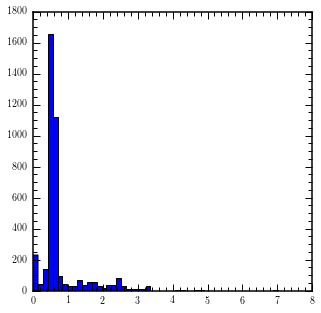

In [21]:
plt.rcParams['figure.figsize'] = 5, 5
plt.hist(dataspec['z_spec'],bins=50)
plt.show()

In [22]:
# Classifying the full set of galaxies
dataspec['class'] = []
for i in range(ngals_tot):
    zp = dataspec['z_spec'][i]
    if dataspec['type'][i] == 'SDSS contaminants':
        dataspec['class'].append('contaminant')
    elif zp < z_ha[1]:
        dataspec['class'].append('Halpha')
#    elif (zp > z_ha[1]) and (zp < z_oiii[1]):
#        dataspec['class'].append('OIII')
#    elif (zp > z_oiii[1]) and (zp < z_hb[1]):
#        dataspec['class'].append('Hbeta')
    elif (zp > z_ha[1]) and (zp < z_hb[1]):
        dataspec['class'].append('OIII+Hbeta')
    elif (zp > 0.5):
        dataspec['class'].append('OII')
    else:
        print 'something is wrong with this redshift: %f'%zp

m_null = np.asarray(dataspec['class']) == 'contaminant'
m_z0  = np.asarray(dataspec['class']) == 'Halpha'
m_zp3 = np.asarray(dataspec['class']) == 'OIII+Hbeta'
#m_zp35 = np.asarray(dataspec['class']) == 'Hbeta'
m_zp7 = np.asarray(dataspec['class']) == 'OII'

n_null = len(dataspec['z_spec'][m_null])
nz0  = len(dataspec['z_spec'][m_z0])
nzp3 = len(dataspec['z_spec'][m_zp3])  
#nzp35 = len(dataspec['z_spec'][m_zp35])  
nzp7 = len(dataspec['z_spec'][m_zp7])
print 'Number of Halpha emitters: %ld' % nz0
print 'Number of OIII+Hbeta emitters: %ld' % nzp3       
#print 'Number of Hbeta emitters: %ld' % nzp35
print 'Number of OII emitters: %ld' % nzp7
print 'Number of contaminants: %ld' % n_null


Number of Halpha emitters: 11
Number of OIII+Hbeta emitters: 61
Number of OII emitters: 18
Number of contaminants: 3782


Number of xmatched ELGs: 16
84
no Halpha in DEEP2
50
57
no Halpha in SDSS contaminants
57
88
5
26
no OII in SDSS contaminants
81
80
0
67
no OIII+Hbeta in SDSS contaminants
19
no contaminant in Alhambra
3570
no contaminant in DEEP2
1170
no contaminant in SDSS
3042
2107


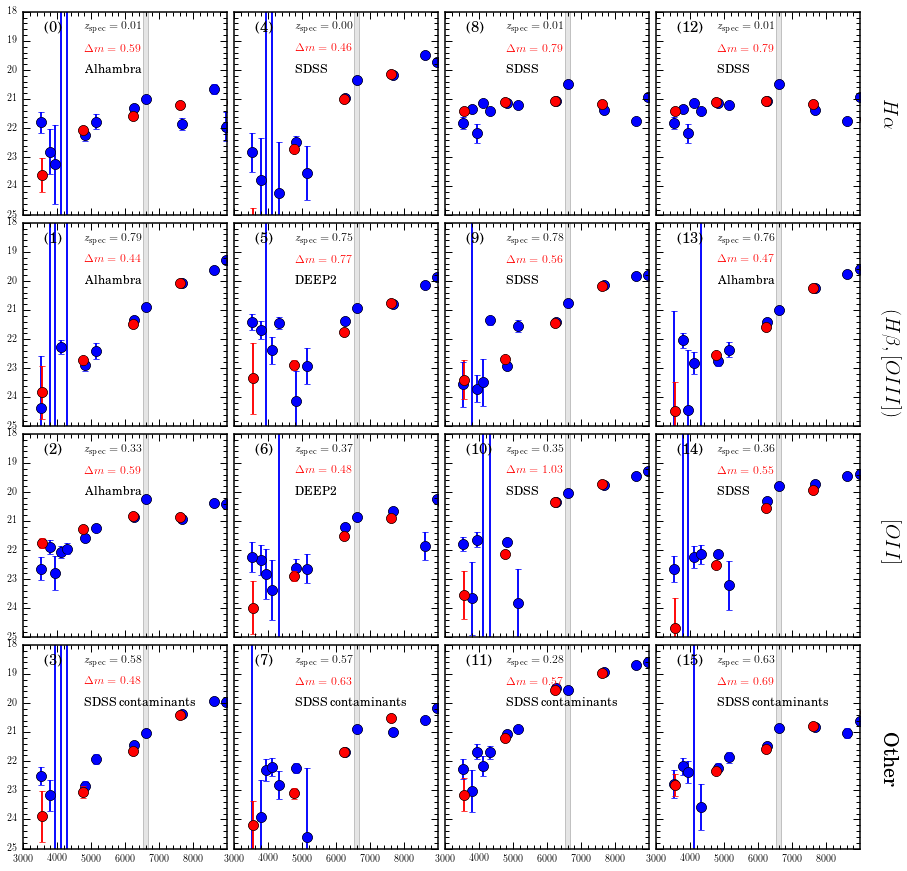

In [25]:
# Plot (some) dataset objects

Plot_TrainingSet = True
import matplotlib.pyplot as plt

if Plot_TrainingSet:

    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','uJAVA', 'gJAVA', 'rJAVA', 'iJAVA','zJAVA']
                #  'uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']

    sdss_fnames = ['uSDSS', 'gSDSS', 'rSDSS', 'iSDSS', 'zSDSS']
    sdss_mw     = [3543, 4770, 6231, 7625, 9134]

  
    grid = [4,4]
    gs = gsc.GridSpec(grid[0],grid[1])
    gs.update(wspace=0.035, hspace=0.035)

    plt.rcParams['figure.figsize'] = 15, 15

    
    nxm = grid[0]*grid[1]
    print 'Number of xmatched ELGs: %ld'%nxm
    
    ix = 0
    iy = 0
    idg = 0
    
    types = np.unique(dataspec['class'])
    sarr= np.unique(dataspec['type'])
    
     
    
    ssarr = [r'$H\alpha$',r'$(H\beta, [OIII])$',r'$[OII]$','Other']
    #types[-1] = 'SDSS'
    sortz = []
    ichoice = []
    for ii in types:
        for jj in sarr:
            nn = np.where((np.asarray(dataspec['class']) == ii) & 
                            (np.asarray(dataspec['type']) ==jj ))[0]
            if len(nn) == 0:
                print 'no %s in %s'% (ii, jj)
                nn = np.where(np.asarray(dataspec['class']) == ii
                            )[0]
            
            ichoice= np.random.choice(nn)
            print ichoice
            sortz.append(ichoice)
        
    for i0 in range(nxm):
        i = sortz[i0]
        ax= plt.subplot(gs[ix,iy])
        idg = ix + grid[0]*iy
        for fname in filternames:
            filt = jplus.tools.fetch_jplus_filter(fname, quiet=True)
    #        print np.median(filt.wave)
            ww = [filt.avgwave(), filt.avgwave()]
            ff = [dataspec[fname][i,0], dataspec[fname][i,0]]

            ax.plot(ww,ff,'o', color='blue', markersize=10)
            ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='blue')

            if fname == 'J0660':# or fname == 'J0378' or fname == 'J0395' or fname=='J0861':
                fwidth = filt.rectwidth()
                ax.fill_between([ww[0] - fwidth/2.,ww[0] + fwidth/2.,ww[0] + fwidth/2.,ww[0] - fwidth/2.],
                            [17,17, 28, 28],facecolor='Grey',alpha=0.2)
            #    mf = np.max(filt.throughput)
            #    ax.fill_between(filt.wave,-25 + (filt.throughput/mf*21)
            #   ,facecolor='Grey',alpha=0.2)
        fw = 0   
        if sdss_fnames[0] in dataspec: # if sdss bands exist
            for fname in sdss_fnames:
                filt = jplus.tools.fetch_sdss_filter(fname, quiet=True)
    #        ww = [filt[0,filt[1,:].argmax()],filt[0,filt[1,:].argmax()]]
                ww = [sdss_mw[fw], sdss_mw[fw]]
                fw += 1
                ff = [dataspec[fname][i,0], dataspec[fname][i,0]]
                ax.plot(ww,ff,'o', color='red', markersize=10)
                ax.errorbar(ww,ff,yerr= dataspec[fname][i,1], color='red')

        ax.text(0.3,0.9,r'$z_{\rm spec}=%.2f$'%dataspec['z_spec'][i], transform= ax.transAxes, fontsize=12)
        ax.text(0.3,0.8,r'$\Delta m=%.2f$'%dataspec['dm_j0660'][i], transform= ax.transAxes, fontsize=12, color='red')
        ax.text(0.3,0.7,dataspec['type'][i], transform= ax.transAxes, fontsize=12, color='black')
        ax.text(0.1,0.9,'(%d)'%idg, transform=ax.transAxes,fontsize=15)
        ax.set_ylim([25, 17.99])
        ax.set_xlim([3000, 8999])
        if ix != grid[0]-1:
            ax.set_xticklabels([])
        if iy >0:
            ax.set_yticklabels([])
        iy +=1
        if iy == grid[1]:
            ax.text(1.1,0.5,ssarr[ix],transform=ax.transAxes, fontsize=20,rotation=-90)
            iy = 0
            ix += 1
            

    plt.show()        



['flags_aper3_gauss_uJAVA', 'flags_aper3_gauss_J0378', 'dm_j0660', 'J0861', 'flags_aper3_worstpsf_J0378', 'fwhm', 'cstar', 'flags_aper3_worstpsf_J0515', 'mag_auto_r', 'flags_aper3_gauss_iJAVA', 'mask_flags_J0515', 'single_detect_J0395', 'uJAVA', 'dm', 'F_j0660', 'single_detect_zJAVA', 'z_spec', 'flags_aper3_gauss_J0515', 'gJAVA', 'norm_wmap_val_J0378', 'J0378', 'norm_wmap_val_rJAVA', 'single_detect_J0515', 'coords', 'flag_J0430', 'flags_aper3_gauss_zJAVA', 'flag_uJAVA', 'flags_aper3_worstpsf_J0861', 'elgcand', 'mask_flags_J0660', 'J0515', 'flags_aper3_worstpsf_J0410', 'mask_flags_gJAVA', 'index', 'flags_aper3_worstpsf_J0430', 'single_detect_gJAVA', 'norm_wmap_val_iJAVA', 'flags_aper3_gauss_J0660', 'single_detect_uJAVA', 'F_cont_j0660', 'err_dm', 'mask_flags_uJAVA', 'norm_wmap_val_J0515', 'flags_aper3_gauss_J0861', 'zSDSS', 'kron_rad', 'XY_IMAGE', 'mask_flags_J0378', 'flag_J0410', 'ids', 'dm_j0660_err', 'single_detect_J0430', 'flags_aper3_worstpsf_J0395', 'rJAVA', 'flag_J0395', 'mask_fl

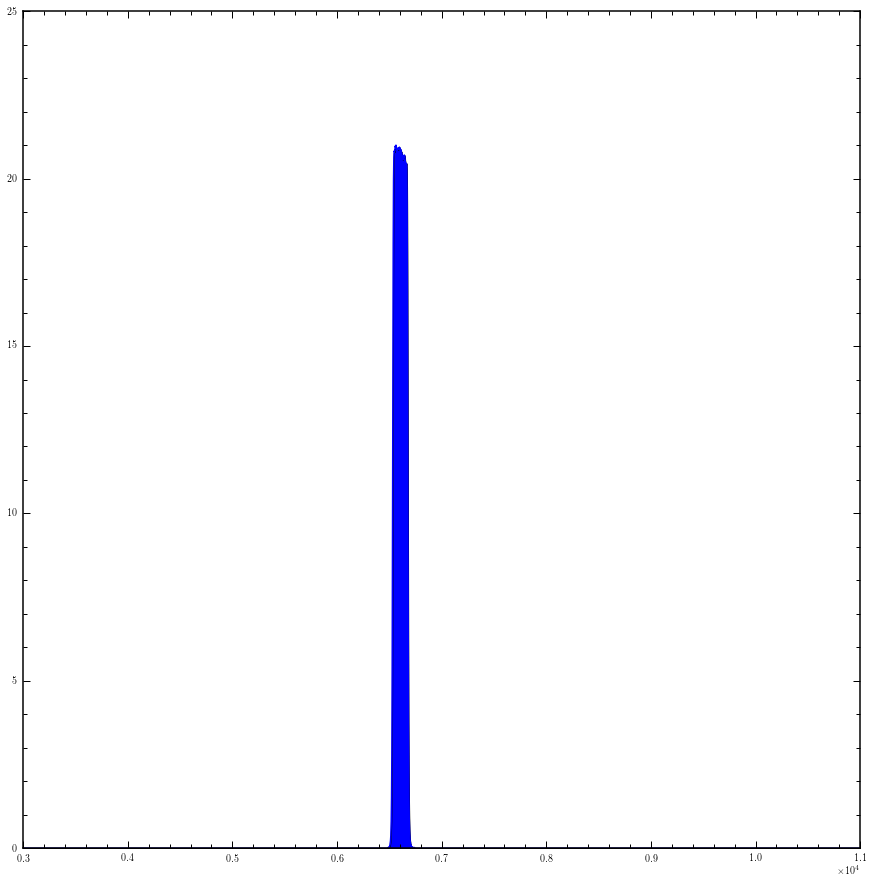

In [ ]:
# Plot distribution of some features for all classes
suff = 'SDSS'
snr = 1./dataspec['r'+suff][:,1]
snr_ha = 1./dataspec['J0660'][:,1]

#classes_names = ['Halpha', 'OIII', 'Hbeta','OII']
classes_names = ['Halpha', 'OIII+Hbeta','OII', 'contaminant']
colors = plt.cm.coolwarm(np.linspace(0,1,len(classes_names)))
iic = 0
plt.figure(1,figsize=(10,3))

for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(snr[mask], bins=20, color=colors[iic], alpha=0.5, label=ic, range=[2,200])
    iic += 1
    
plt.xlabel('r SNR',fontsize=20)
plt.xlim([0,200])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(2,figsize=(10,4))

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(snr_ha[mask], bins=20, color=colors[iic], alpha=0.5, label=ic, range=[2,100])
    iic += 1

plt.xlabel('J0660 SNR',fontsize=20)
plt.xlim([0,100])
plt.legend()
plt.yscale('log', nonposy='clip')


plt.figure(3,figsize=(10,4))

iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['mu_max_r'][mask]-dataspec['rJAVA'][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic)
    iic += 1

plt.xlabel(r'$\mu_{\rm max}- rJAVA$',fontsize=20)
#plt.xlim([0,100])
plt.legend()
plt.yscale('log', nonposy='clip')

#plt.figure(4,figsize=(10,4))
#suff = 'SDSS'

#iic= 0
#for ic in classes_names:
#    mask = np.asarray(dataspec['class']) == ic
#    plt.hist(dataspec['dm_j0660'][mask], bins=20, color=colors[iic], alpha=0.5, label=ic,range=[0,2])
#    iic += 1

#plt.xlabel(r'$C^{r,g} - J0660$',fontsize=20)
#plt.xlim([-0.5,2])
#plt.legend()
#plt.yscale('log', nonposy='clip')

plt.figure(5,figsize=(10,3))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['g'+suff][mask,0] - dataspec['r'+suff][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic)#,range=[0,2])
    iic += 1

plt.xlabel(r'$g-r$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(6,figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['u'+suff][mask,0] - dataspec['z'+suff][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic)#,range=[0,2])
    iic += 1

plt.xlabel(r'$u-z$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(7,figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0861'][mask,0] - dataspec['z'+suff][mask,0], bins=20, color=colors[iic], alpha=0.5, label=ic,range=[-2,2])
    iic += 1

plt.xlabel(r'$J0861-z$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure(8,figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    right_col = dataspec['r'+suff][mask,0]-dataspec['J0660'][mask,0]
    left_col = dataspec['g'+suff][mask,0]-dataspec['J0660'][mask,0]
    plt.hist(right_col/left_col, bins=20, color=colors[iic], alpha=0.5, label=ic)
    iic += 1

plt.xlabel(r'$(r-J0660)/(g-J0660)$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('j0395-g',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0395'][mask,0] - dataspec['g'+suff][mask,0], bins=10, color=colors[iic], alpha=0.5, 
             label=ic, range=[-2,2])
    iic += 1

plt.xlabel(r'$J0395-g$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('j0410-g',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0410'][mask,0] - dataspec['g'+suff][mask,0], bins=10, color=colors[iic], alpha=0.5, 
             label=ic, range=[-2,2])
    iic += 1

plt.xlabel(r'$J0410-g$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('j0430-g',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0430'][mask,0] - dataspec['g'+suff][mask,0], bins=10, color=colors[iic], alpha=0.5, 
             label=ic, range=[-2,2])
    iic += 1

plt.xlabel(r'$J0430-g$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('j0515-g',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0515'][mask,0] - dataspec['g'+suff][mask,0], bins=10, color=colors[iic], alpha=0.5, 
             label=ic, range=[-2,2])
    iic += 1

plt.xlabel(r'$J0515-g$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('j0378-u',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0378'][mask,0] - dataspec['u'+suff][mask,0], bins=10, color=colors[iic], alpha=0.5, 
             label=ic, range=[-2,2])
    iic += 1

plt.xlabel(r'$J0378-u$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('j0395-u',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['J0395'][mask,0] - dataspec['u'+suff][mask,0], bins=10, color=colors[iic], alpha=0.5, 
             label=ic, range=[-2,2])
    iic += 1

plt.xlabel(r'$J0395-u$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')



bb = ['u','g','r','i','z']

for band in bb:
    plt.figure(band,figsize=(10,4))


    iic= 0
    for ic in classes_names:
        mask = np.asarray(dataspec['class']) == ic
        plt.hist(dataspec[band+suff][mask,0] , bins=20, color=colors[iic], alpha=0.5, label=ic)
        iic += 1

    plt.xlabel(r'$%s%s$'%(band,suff),fontsize=20)
    #plt.xlim([-0.5,2])
    plt.legend()
    plt.yscale('log', nonposy='clip')



pzarr = ['leph', 'tpz', 'bpz']    

for pz in pzarr:
    plt.figure(pz,figsize=(10,4))


    iic= 0
    for ic in classes_names:
        mask = np.asarray(dataspec['class']) == ic
        plt.hist(dataspec['photoz_'+pz][mask], bins=20, color=colors[iic], alpha=0.5, label=ic, range=[0,1])
        iic += 1

    plt.xlabel(r'$z_{\rm %s}$'%pz,fontsize=20)
    #plt.xlim([-0.5,2])
    plt.legend()
    plt.yscale('log', nonposy='clip')


    
plt.figure('dm_j0660',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['dm_j0660'][mask], bins=20, color=colors[iic], alpha=0.5, label=ic)
    iic += 1

plt.xlabel(r'$C - J0660$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('dm_j0660_err',figsize=(10,4))


iic= 0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    plt.hist(dataspec['dm_j0660_err'][mask], bins=20, color=colors[iic], alpha=0.5, label=ic)
    iic += 1

plt.xlabel(r'$err(C - J0660)$',fontsize=20)
#plt.xlim([-0.5,2])
plt.legend()
plt.yscale('log', nonposy='clip')

plt.figure('cc1')

from matplotlib.colors import LogNorm

iic =0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    if ic == 'contaminant':
        counts, ybins, xbins, image = plt.hist2d(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['i'+suff][mask,0] - dataspec['J0660'][mask,0], bins=80, 
                                         cmap=plt.cm.Reds, normed=LogNorm(), 
                                         cmin=0.01, label='SDSS contaminants', alpha=0.7)
        plt.legend(loc='upper left')
    else:
        plt.plot(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['i'+suff][mask,0] - dataspec['J0660'][mask,0],
             'o',color=colors[iic],alpha=1,label=ic,markersize=15)
    iic += 1

plt.xlabel(r'$rSDSS-J0660$',fontsize=20)
plt.ylabel(r'$iSDSS-J0660$',fontsize=20)

#plt.xlim([-0.5,2])
plt.legend()
             
plt.figure('cc2')

from matplotlib.colors import LogNorm

xr = [-.5,1.5]
yr = [-1,3.5]

iic =0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    if ic == 'contaminant':
        counts, ybins, xbins, image = plt.hist2d(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['g'+suff][mask,0] - dataspec['J0660'][mask,0], bins=80, 
                                         cmap=plt.cm.Reds, normed=LogNorm(), 
                                         cmin=0.01, label='SDSS contaminants', alpha=0.7,
                                                range=[xr,yr])
        plt.legend(loc='upper left')
    else:
        plt.plot(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['g'+suff][mask,0] - dataspec['J0660'][mask,0],
             'o',color=colors[iic],alpha=1,label=ic,markersize=15)
    iic += 1
plt.ylim(yr)
plt.xlim(xr)
plt.xlabel(r'$r%s-J0660$'%suff,fontsize=20)
plt.ylabel(r'$g%s-J0660$'%suff,fontsize=20)



#plt.xlim([-0.5,2])
plt.legend()



   

In [25]:
#Focusing on synthetic photometry
apply_mask = True
synth_spec = []


suff ='SDSS'
photo_spec['dm_j0660'], Fline, Fcont = mtools.gen_3fm(photo_spec['J0660'][:,0],  
                    photo_spec['r'+suff][:,0], photo_spec['g'+suff][:,0], 
                    Broad_NoLineName='g'+suff)



mask = photo_spec['dm_j0660'] > 0.1

eboss_id = []
vvds_id  = []
nspec = len(allspec)
print allspec[0].keys()
for i in range(nspec):
    synth_spec.append(i)
    if allspec[i]['survey'] == 'eBOSS':
        eboss_id.append(i)
    elif allspec[i]['survey'] == 'VVDS-F02_UDEEP':
        vvds_id.append(i)
    else:
        print allspec[i]['survey']
        
print len(eboss_id), len(vvds_id)
        
gtype = ['Halpha','OIII', 'OII', 'Hbeta']
gtdict = {}

for gt in gtype:
    gtdict[gt] = []
    for sp in synth_spec:
        if allspec[sp]['name'] == gt:
            if mask[sp]:
                gtdict[gt].append(sp)

for gtype in gtdict.keys():
    print 'Number of %s: %d'% (gtype, len(gtdict[gtype]))




['w', 'flux', 'survey', 'file', 'z', 'name']
587 61
Number of Halpha: 0
Number of Hbeta: 22
Number of OIII: 61
Number of OII: 254


In [29]:
print photo_spec.keys()


['uJAVA', 'rSDSS', 'gJAVA', 'iSDSS', 'iJAVA', 'gSDSS', 'J0395', 'zSDSS', 'J0378', 'J0430', 'uSDSS', 'dm_j0660', 'J0660', 'J0410', 'zJAVA', 'J0515', 'J0861', 'rJAVA']


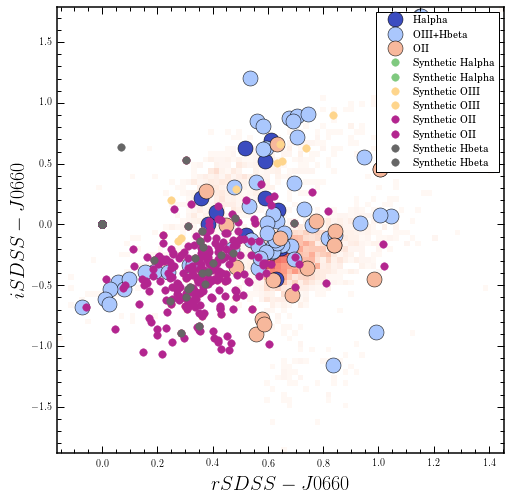

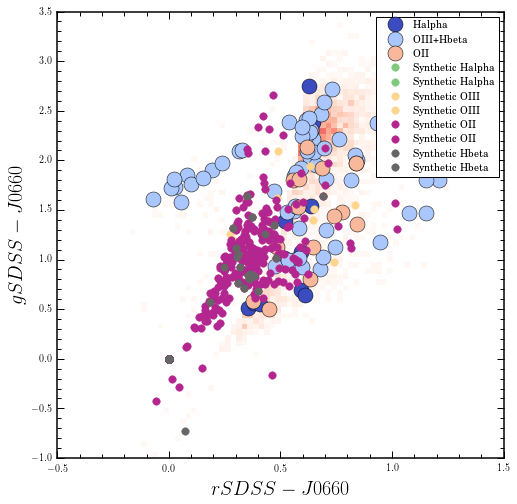

In [26]:
# Explore those colour-colour plots again now with synthetic photometry and adding
# cuts to reduce the fraction of contaminants

classes_names = ['Halpha','OIII+Hbeta','OII', 'contaminant']

plt.figure('ccx1',figsize=(8,8))
colors = plt.cm.coolwarm(np.linspace(0,1,len(classes_names)))
colors_synt = plt.cm.Accent(np.linspace(0,1,4))
suff = 'SDSS'
gtype = ['Halpha','OIII', 'OII', 'Hbeta']



from matplotlib.colors import LogNorm

iic =0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    if ic == 'contaminant':
        counts, ybins, xbins, image = plt.hist2d(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['i'+suff][mask,0] - dataspec['J0660'][mask,0], bins=80, 
                                         cmap=plt.cm.Reds, normed=LogNorm(), 
                                         cmin=0.01, label='SDSS contaminants', alpha=0.7)
        #plt.legend(loc='upper left')
    else:
        plt.plot(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['i'+suff][mask,0] - dataspec['J0660'][mask,0],
             'o',color=colors[iic],alpha=1,label=ic,markersize=15)
    iic += 1

# Add synthetic photometry from eBOSS
iic = 0
for ic in gtype:
    iid = gtdict[ic]
    plt.plot(photo_spec['r'+suff][iid] - photo_spec['J0660'][iid], 
             photo_spec['i'+suff][iid] - photo_spec['J0660'][iid],
             '.',color=colors_synt[iic],alpha=1,label='Synthetic %s'%ic,markersize=15)

    iic += 1
    
plt.xlabel(r'$r%s-J0660$'%suff,fontsize=20)
plt.ylabel(r'$i%s-J0660$'%suff,fontsize=20)

#plt.xlim([-0.5,2])
plt.legend()
             
plt.figure('cc2',figsize=(8,8))

from matplotlib.colors import LogNorm

xr = [-.5,1.5]
yr = [-1,3.5]

iic =0
for ic in classes_names:
    mask = np.asarray(dataspec['class']) == ic
    if ic == 'contaminant':
        counts, ybins, xbins, image = plt.hist2d(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['g'+suff][mask,0] - dataspec['J0660'][mask,0], bins=80, 
                                         cmap=plt.cm.Reds, normed=LogNorm(), 
                                         cmin=0.01, label='SDSS contaminants', alpha=0.7,
                                                range=[xr,yr])
        #plt.legend(loc='upper left')
    else:
        plt.plot(dataspec['r'+suff][mask,0] - dataspec['J0660'][mask,0],
             dataspec['g'+suff][mask,0] - dataspec['J0660'][mask,0],
             'o',color=colors[iic],alpha=1,label=ic,markersize=15)
    iic += 1

iic = 0
for ic in gtype:
    iid = gtdict[ic]
    plt.plot(photo_spec['r'+suff][iid] - photo_spec['J0660'][iid], 
             photo_spec['g'+suff][iid] - photo_spec['J0660'][iid],
             '.',color=colors_synt[iic],alpha=1,label='Synthetic %s'%ic,markersize=15)

    iic += 1


    
plt.ylim(yr)
plt.xlim(xr)
plt.xlabel(r'$r%s-J0660$'%suff,fontsize=20)
plt.ylabel(r'$g%s-J0660$'%suff,fontsize=20)



#plt.xlim([-0.5,2])
plt.legend()



In [31]:
# additional cuts on training set to reduce contaminants
suff ='SDSS'
gj0660 = 2.0
mask2 = (dataspec['g'+suff][:,0] - dataspec['J0660'][:,0]) < gj0660

#dataspec_new = 

print 'old fraction of contaminants: %.3f'% ((0.0+len(np.where(np.asarray(dataspec['class']) == 'contaminant')[0]))/
                                             (0.0+len(dataspec['class'])))
print 'new fraction: %.3f'% ((0.0+len(np.where(np.array(mask2))[0]))/len(dataspec['class']))

print len(np.where(np.array(mask2))[0])


old fraction of contaminants: 0.977
new fraction: 0.390
1512


In [32]:
# This will add synthetic spectra to the dataset for training and testing
Add_Synthetic_to_DataSet = True

data_merged = {}

keys_to_copy = photo_spec.keys()
mask_sp = photo_spec['g'+suff][:,0] - photo_spec['J0660'][:,0] < gj0660

print gtype

for key in dataspec.keys():
    if type(dataspec[key]) is np.ndarray:
        data_merged[key] = dataspec[key][mask2].tolist() # first copy all dataspec into merged dataset
    else:
        data_merged[key] = np.array(dataspec[key])[mask2].tolist()
        
for gt in gtype: #for each new class
    iid = gtdict[gt]
    cname = 'OIII+Hbeta' if gt == 'Hbeta' or gt == 'OIII' else 'OII'
    for _i in iid: # and each new object
        if mask_sp[_i]: # if object is not masked
            for key in keys_to_copy: #append on each key
                data_merged[key].append(photo_spec[key][_i])
            data_merged['class'].append(cname)

data_merged['index'] = np.arange(len(data_merged['class']))
data_merged['class'] = np.array(data_merged['class']) 

print 'converting lists to arrays...'
for key in keys_to_copy:
    data_merged[key] = np.array(data_merged[key])


m_null = np.asarray(data_merged['class']) == 'contaminant'
m_z0  = np.asarray(data_merged['class']) == 'Halpha'
m_zp3 = np.asarray(data_merged['class']) == 'OIII+Hbeta'
#m_zp35 = np.asarray(dataspec['class']) == 'Hbeta'
m_zp7 = np.asarray(data_merged['class']) == 'OII'

print m_null
print data_merged['class']
n_null = len(data_merged['class'][m_null])
nz0  = len(data_merged['class'][m_z0])
nzp3 = len(data_merged['class'][m_zp3])  
#nzp35 = len(dataspec['z_spec'][m_zp35])  
nzp7 = len(data_merged['class'][m_zp7])
print 'Number of Halpha emitters: %ld' % nz0
print 'Number of OIII+Hbeta emitters: %ld' % nzp3       
#print 'Number of Hbeta emitters: %ld' % nzp35
print 'Number of OII emitters: %ld' % nzp7
print 'Number of contaminants: %ld' % n_null



['OIII', 'OII', 'Hbeta']
converting lists to arrays...
[False False False ... False False False]
['OIII+Hbeta' 'OIII+Hbeta' 'OII' ... 'OIII+Hbeta' 'OIII+Hbeta'
 'OIII+Hbeta']
Number of Halpha emitters: 9
Number of OIII+Hbeta emitters: 116
Number of OII emitters: 261
Number of contaminants: 1452


In [33]:
# This function retrieves a features list for a single object.

def prepare_sample(data, index, sample_amp = False, 
                   sample_error = False, sample_type = 'All_Mags', 
                   filters='J-PLUS'):
    
    BBNames = ['u','g','r','i','z']
    NBNames = ['J0378', 'J0395', 'J0410','J0430','J0515','J0660','J0861']
    
    suff = 'JAVA' if filters == 'J-PLUS' else 'SDSS'
    
    filternames = [ 'J0378','J0395', 'J0410','J0430','J0515', 'J0660',
                   'J0861','u'+suff, 'g'+suff, 'r'+suff, 'i'+suff,'z'+suff]
        
        
    
    flist = [] # filterslist
    ferrlist = []
    nfilters = len(filternames)
    a_r = data['r'+suff][index,0]
    amplitude = np.random.uniform(18, 23) if sample_amp else a_r  # amplitude scaling change for r-filter
    DeltaM = amplitude - a_r
    for ff in filternames:
        if sample_error and data[ff][index,1] > 0:
            flist.append(np.random.normal(data[ff][index,0], data[ff][index,1]) + DeltaM)  # errors distribute like a gaussian (?)
        else:
            flist.append(data[ff][index,0] + DeltaM)
        ferrlist.append(data[ff][index,1])
    
    sample = [] # The sample's features
    
#    dm_J0515 = mtools.gen_3fm(data['J0515'][index,0], data['g'+suff][index,0], 
#                          data['r'+suff][index,0],Broad_NoLineName='rSDSS', LineFilterName='J0515', 
#                          Broad_LineName='gSDSS')
#    err_dm_J0515 = mtools.gen_3fm_err(data['J0515'][index,0], data['J0515'][index,1], data['g'+suff][index,0], 
#                                      data['g'+suff][index,1], data['r'+suff][index,0], data['r'+suff][index,1],
#                                      Broad_NoLineName='rSDSS')


#    dm_J0378 = mtools.gen_3fm(data['J0378'][index,0], data['u'+suff][index,0], 
#                          data['g'+suff][index,0],Broad_NoLineName='gSDSS', LineFilterName='J0378', 
#                              Broad_LineName='uJAVA')
##    err_dm_J0378 = mtools.gen_3fm_err(data['J0378'][index,0], data['J0378'][index,1], data['u'+suff][index,0], 
#                                      data['u'+suff][index,1],data['g'+suff][index,0], data['g'+suff][index,1],
#                                      Broad_NoLineName='gSDSS')

#    dm_J0861 = mtools.gen_3fm(data['J0861'][index,0], data['z'+suff][index,0], 
#                          data['i'+suff][index,0],Broad_NoLineName='iSDSS', 
#                          LineFilterName='J0861', Broad_LineName='zSDSS')

#    err_dm_J0861 = mtools.gen_3fm_err(data['J0861'][index,0], data['J0861'][index,1], data['z'+suff][index,0], 
#                          data['z'+suff][index,1],data['i'+suff][index,0], data['i'+suff][index,1],
#                          Broad_NoLineName='iSDSS')

#    dm_J0660 = mtools.gen_3fm(data['J0660'][index,0], data['r'+suff][index,0], 
#                          data['g'+suff][index,0],Broad_NoLineName='gSDSS', 
#                          LineFilterName='J0660', Broad_LineName='rSDSS')

    dm_J0660 = data['dm_j0660'][index]

#    err_dm_J0660 = mtools.gen_3fm_err(data['J0660'][index,0], data['J0660'][index,1], data['r'+suff][index,0], 
#                          data['r'+suff][index,1],data['g'+suff][index,0], data['g'+suff][index,1],
#                          Broad_NoLineName='gSDSS')

    
    # Here I should get creative
    if sample_type == 'All_Mags':
        sample = flist # All individual filters
    if sample_type == 'All_Mags_mumax':
        for i in range(nfilters):
            sample.append(flist[i])
        sample.append(data['mu_max_r'][index] - data['rJAVA'][index,0])
        #sample.append(data['cstar'][index])
#        sample.append(data['pz_bpz'][index])
    if sample_type == 'Colors':
        for i in range(nfilters):
            sample.append(flist[i])
            for j in range(nfilters):
                if i != j:
                    sample.append(flist[i] - flist[j])
                   
    if sample_type == 'All':
        for i in range(nfilters):
            sample.append(flist[i])
        sample.append(data['mu_max_r'][index])
        #sample.append(data['cstar'][index])
        sample.append(data['pz_bpz'][index])
        for i in range(nfilters):
            sample.append(flist[i])
            for j in range(nfilters):
                if i != j:
                    sample.append(flist[i] - flist[j]) 
    if sample_type == 'dm':
        # Delta-m and SNR of deltaMs...
        sample=[#dm_J0515, #1./err_dm_J0515,
                #dm_J0378, #1./err_dm_J0378,
                #dm_J0861#, 1./err_dm_J0861
               dm_J0660]#, err_dm_J0660 ]
                 #data['dm'][index],data['err_dm'][index]
                 #]
        #sample.append(data['mu_max_r'][index] - data['rJAVA'][index,0])
        
    
        for fff in BBNames:
            sample.append(np.random.normal(data[fff+suff][index,0], data[fff+suff][index,1]) + DeltaM
            if sample_error and data[fff+suff][index,1] > 0 else data[fff+suff][index,0] + DeltaM)
        
        for nb in NBNames:
            sample.append(np.random.normal(data[nb][index,0], data[nb][index,1]) + DeltaM
            if sample_error and data[nb][index,1] > 0 else data[nb][index,0] + DeltaM)

        
        #u-g
        sample.append(np.random.normal(data['u'+suff][index,0], data['u'+suff][index,1])-
                      np.random.normal(data['g'+suff][index,0], data['g'+suff][index,1])
                      if sample_error and data['g'+suff][index,1] > 1 else 
                      data['u'+suff][index,0]-data['g'+suff][index,0])
        
        #g-r
        sample.append(np.random.normal(data['g'+suff][index,0], data['g'+suff][index,1])-
                      np.random.normal(data['r'+suff][index,0], data['r'+suff][index,1])
                      if sample_error and data['g'+suff][index,1] > 0 else 
                      data['g'+suff][index,0]-data['r'+suff][index,0])

        #r-i
        sample.append(np.random.normal(data['r'+suff][index,0], data['r'+suff][index,1])-
                      np.random.normal(data['i'+suff][index,0], data['i'+suff][index,1])
                      if sample_error and data['r'+suff][index,1] > 0 
                      else data['r'+suff][index,0]-data['i'+suff][index,0])

        #i-z
        sample.append(np.random.normal(data['i'+suff][index,0], data['i'+suff][index,1])-
                      np.random.normal(data['z'+suff][index,0], data['z'+suff][index,1])
                      if sample_error and data['r'+suff][index,1] > 0
                      else data['i'+suff][index,0]-data['z'+suff][index,0])

        #u-z
        sample.append(np.random.normal(data['u'+suff][index,0], data['u'+suff][index,1])-
                    np.random.normal(data['z'+suff][index,0], data['z'+suff][index,1])
                      if sample_error and data['r'+suff][index,1] > 0 else 
                      data['u'+suff][index,0]-data['z'+suff][index,0])
        
        #r-z
        sample.append(np.random.normal(data['r'+suff][index,0], data['r'+suff][index,1])-
                     np.random.normal(data['z'+suff][index,0], data['z'+suff][index,1])
                      if sample_error  and data['r'+suff][index,1] > 0
                      else data['r'+suff][index,0]-data['z'+suff][index,0])
        
        
        # colors including NBs
        
        #
        
        
        
        #SNR in r-band
        #sample.append(1./data['r'+suff][index,1])
        #SNR in J0660 band
        #sample.append(1./data['J0660'][index,1])
        
        # r-band
        #sample.append(np.random.normal(data['r'+suff][index,0] if sample_error 
        #                            and data['r'+suff][index,1] > 0 else data['r'+suff][index,0]))
        #g-band
        #sample.append(np.random.normal(data['g'+suff][index,0] if sample_error else data['g'+suff][index,0]))
        
        
        
    return sample



In [34]:
dset = data_merged  #use dataspec for xmatches only, data_merged to include synthetic photometry 


Compute_Dataset = True   # if False it reads a dataset from a file

Training_set_class_frac = 1 # a fraction X of the less abundant determines the number of objects per class in the training set.
Sampling_errors         = 2  # Each training galaxy is resampled X times using its errors


# Set only one of these to True
Sample_Small_Only = False       # If True, it will resample only the class with the smallest sample
Sample_Balancing  = True        # All classes are resampled but the end result is balanced
UseFixedNum       = False       # Use a fixed number of objects per class

# indices of different categories of objects
id_z0   = dset['index'][m_z0] 
id_z0p3 = dset['index'][m_zp3]
#id_z0p35 = dataspec['index'][m_zp35]
id_z0p7 = dset['index'][m_zp7]
id_null = dset['index'][m_null]

#nzarr = [nz0, nzp3, nzp35, nzp7]
nzarr = [nzp3, nzp7, n_null]
min_class = np.min(nzarr)
id_min    = np.argmin(nzarr)
id_max    = np.argmax(nzarr)

MaxClass = Sampling_errors * nzarr[id_max] 

if Sample_Balancing:
    print 'MaxClass = %d'%MaxClass

    balance_factors= [int((MaxClass+0.)/i) for i in nzarr]

if UseFixedNum:
    numperclass = int(min_class*Training_set_class_frac)
    print 'number of objects in training set per class before sampling errors: %d'%numperclass
    print 'number of objects left for validation: %d'%(ngals_tot-numperclass*3)
    
# Randomised lists:
ran_idz0 = np.random.permutation(id_z0)
ran_idz0p3 = np.random.permutation(id_z0p3)    
#ran_idz0p35 = np.random.permutation(id_z0p35)    
ran_idz0p7 = np.random.permutation(id_z0p7)
ran_id_null = np.random.permutation(id_null)

#id_arr = [ran_idz0, ran_idz0p3, ran_idz0p35, ran_idz0p7]
id_arr = [ran_idz0p3, ran_idz0p7, ran_id_null]

training_features = []
training_class    = []

dataset_features = []
dataset_class    = []

validate_features = []
validate_class    = []


sample_type='dm'
filterset = 'SDSS'

if Compute_Dataset:

    DoSampling = True if Sampling_errors >= 1 else False

    iid = 0
    for id_obj in id_arr:
        nid = numperclass if UseFixedNum else int(len(id_obj))

        if Sample_Small_Only:
            DoSampling = True if (Sampling_errors >= 1) and (iid == id_min) else False
            Serr = 1
        else:
            Serr = Sampling_errors

        if Sample_Balancing:
            DoSampling = True
            Serr = balance_factors[iid]
            print 'Balancing sample %d with resampling %d'% (iid, Serr)
            if Serr == 1:
                DoSampling = False # do not resample the largest class
                
        iclass = 0
        for i in range(nid):
            for j in range(Serr):
                dataset_features.append(prepare_sample(dset, id_obj[i], sample_error=DoSampling, sample_amp = DoSampling, 
                                                        sample_type=sample_type, filters=filterset))
                dataset_class.append(dset['class'][id_obj[i]])
                iclass += 1
        iid += 1
        print 'Number of elements in class %d: %d'%(iid, iclass)


    if Training_set_class_frac < 1:    # if == 1 then CV is used instead
        # randomize dataset:
        ndata = len(dataset_class)
        idsort = np.random.permutation(ndata) # permutation of indices
         
        idtr = int(ndata*Training_set_class_frac) #fraction used for training
        id_train = idsort[0:idtr]
        id_val   = idsort[idtr:]
        
        print idtr, ndata, len(id_val)
        training_features = [dataset_features[_idt] for _idt in id_train]
        training_class    = [dataset_class[_idt] for _idt in id_train]
        
        validate_features  = [dataset_features[_idv] for _idv in id_val]
        validate_class    = [dataset_class[_idv] for _idv in id_val]
    else:
        training_features = dataset_features
        training_class = dataset_class
        validate_features = dataset_features
        validate_class = dataset_class
        
        
        
    

    # Save dataset to a file
    datatrain = {'tfeatures':training_features,
                   'tclass'   :training_class,
                   'vfeatures':validate_features,
                   'vclass'   :validate_class}

    print 'saving file'
    print datatrain.keys()
    with open('dataset.data','wb') as outfile:
        pickle.dump(datatrain,outfile,protocol=pickle.HIGHEST_PROTOCOL)  

else:
    datatrain = pickle.load(open('dataset.data'))
    training_features = datatrain['tfeatures']
    training_class    = datatrain['tclass']
    validate_features = datatrain['vfeatures']
    validate_class    = datatrain['vclass']
    

print 'number of objects in training set: %ld'%len(training_features)        
print 'number of objects in validation set: %ld'%len(validate_features)        

#for i in range(len(training_features)):
#    print training_features[i], training_class[i]
    
print 'Number of features: %ld' % len(training_features[0])
ntrain = len(training_features)     
nfeat = len(training_features[0])



MaxClass = 2904
Balancing sample 0 with resampling 25
Number of elements in class 1: 2900
Balancing sample 1 with resampling 11
Number of elements in class 2: 2871
Balancing sample 2 with resampling 2
Number of elements in class 3: 2904
saving file
['tfeatures', 'vclass', 'tclass', 'vfeatures']
number of objects in training set: 8675
number of objects in validation set: 8675
Number of features: 19


In [ ]:
# Save data for ML analysis elsewhere




In [ ]:
#Taken from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#mlcolors[index]
def summary_performance_plot(index,precision, recall, fscore, color, 
                             cnum, ctype, name,  gs, 
                             figname='summary', ylim = [.0, 1.1], thick= 3,lsize=20):
    
    
    ax = plt.subplot(gs[0])
    ax.plot(cnum, precision,'o-', label=name, color=color,linewidth=thick)
    ax.grid(True)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(ctype)
    ax.set_title('Precision',fontsize=lsize)
    ax.set_xlim([-0.25,2.25])
    ax.set_ylim(ylim)
    ax.legend(loc='lower left',fontsize=lsize)
    
    ax.tick_params(axis='both', which='major', labelsize=lsize)
    ax.tick_params(axis='both', which='minor', labelsize=lsize)
    
    ax = plt.subplot(gs[1])
    ax.plot(cnum, recall,'o-', label=name, color=color,linewidth=thick)
    ax.grid(True)
    ax.set_xticks([0,1,2, 3])
    ax.set_xticklabels(ctype)
    ax.set_title('Recall',fontsize=lsize)
    ax.set_xlim([-0.25,2.25])
    ax.set_ylim(ylim)
    ax.set_yticklabels([])
    
    ax.tick_params(axis='both', which='major', labelsize=lsize)
    ax.tick_params(axis='both', which='minor', labelsize=lsize)
    if index == 0:
        ax.text(0.5,1.15, figname, fontsize=lsize, transform=ax.transAxes)
    
  #  ax.legend(loc='lower left',fontsize=10)
    
    ax = plt.subplot(gs[2])
    ax.plot(cnum, fscore,'o-', label=name, color=color, linewidth=thick)
    ax.grid(True)
    ax.set_xticks([0,1,2, 3])
    ax.set_xticklabels(ctype)
    ax.set_title('Fscore',fontsize=lsize)
    ax.set_xlim([-0.25,2.25])
    ax.set_ylim(ylim)
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=lsize)
    ax.tick_params(axis='both', which='minor', labelsize=lsize)

   # ax.legend(loc='lower left',fontsize=10)
    
    return
    

In [ ]:
# Run ML
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn import tree
from sklearn import svm 

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF 

from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

import sklearn
print sklearn.__version__

In [ ]:
# First validate the training set
UseCV = False # Use Stratified-Cross-validation to optimise the use of the dataset
if UseCV:
    from sklearn.model_selection import StratifiedKFold
    
if Training_set_class_frac == 1: # Do the splitting automatically instead of defined as above
    traf, valf, trac, valc = train_test_split(
    training_features, training_class, test_size=0.2, random_state=None)
else:
    traf = training_features
    valf = validation_features
    trac = training_class
    valc = validation_class
    
Scaledata = True

if Scaledata:
    print 'scaling data...',
    scaler = StandardScaler()
    scaler.fit(traf)
    Traindata = scaler.transform(traf)
    Testdata  = scaler.transform(valf)
    print 'done'
else:
    Traindata = traf
    Testdata  = valf    

classifiers = {}

import numpy as np

nalpha = 10

a_arr = np.logspace(-3,0,num=nalpha)
niter = 1
iter_arr = np.linspace(1000,1000,niter)
nff = int(nfeat)
for aa in range(nalpha):
    for bbin in iter_arr:
        alpha = a_arr[aa]
        itt = bbin
        print alpha
        classifiers['MLP alpha=%.7f\niter=%d'%(alpha,itt)] = MLPClassifier(solver='lbfgs',
                                                hidden_layer_sizes=(nff),
                                                activation='relu', alpha=alpha,
                                                             random_state=3455, tol=1e-5, 
                                                              max_iter=itt)



cnum = [0, 1, 2]
#ctype = ['Halpha', 'OIII', 'Hbeta','OII']
ctype = ['OIII+Hbeta','OII','contaminant']
nclass = 1
mlcolors = plt.cm.Accent(np.linspace(0,1,nalpha+niter))

#plt.figure('summary')

plt.figure('performance')
plt.rcParams['figure.figsize'] = 15, 10
gs = gsc.GridSpec(1,3)
gs.update(wspace=0.0, right=1.5,top=0.6)

gs2 = gsc.GridSpec(1,3)
gs2.update(wspace=0.0, right=1.5,top=0.6)



iid = 0
for index in range(nalpha):
    for itt in iter_arr:
        alpha = a_arr[index]
        name = 'MLP alpha=%.7f\niter=%d'%(alpha,itt)
        sname = r'$\alpha=%.4f$'%alpha
        classifier = classifiers[name]
        print name
#        if UseCV:
#            skf = StratifiedKFold(n_splits=5)
#            ndata = len(Traindata)
#            id_data = np.ones(ndata)
#            for train, test in skf.split(Traindata, training_class):
            
#        else:
            
        classifier.fit(Traindata, trac)
        y_train = classifier.predict(Traindata)
        y_test  = classifier.predict(Testdata)

        precision, recall, fscore, support = metrics.precision_recall_fscore_support(trac, 
                                                                                     y_train, labels=ctype)
        color = mlcolors[index]
        plt.figure('performance')
        plt.rcParams['figure.figsize'] = 15, 10

        summary_performance_plot(index,precision, recall, fscore, color, cnum, ctype, sname,  gs, figname='Training', ylim=[0.7,1.05])

        precision, recall, fscore, support = metrics.precision_recall_fscore_support(valc, 
                                                                                     y_test, labels=ctype)
        color = mlcolors[iid]
        plt.figure('performance2')
        plt.rcParams['figure.figsize'] = 15, 10

        summary_performance_plot(index,precision, recall, fscore, color, cnum, ctype, sname,  gs2, figname='Validation', ylim=[0.7,1.05])
        iid += 1



In [ ]:
# Perform recursive feature elimination with cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

filterset = 'SDSS'

feat_data = []

best_alpha = 0.0022
best_iter  = 1000
ctype = ['OIII+Hbeta','OII','contaminant']

plt.figure('performance')
plt.rcParams['figure.figsize'] = 15, 10
gs = gsc.GridSpec(1,3)
gs.update(wspace=0.2, right=1.5,top=0.6)

gs2 = gsc.GridSpec(1,3)
gs2.update(wspace=0.0, right=1.5,top=0.6)


# Train again a specific classifier(s)

classifier = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(nff,nff),
                            activation='relu', alpha=best_alpha,
                            random_state=3455, tol=1e-5, 
                            max_iter=best_iter)

#rfecv = RFECV(estimator=classifier, step=1, cv=StratifiedKFold(2),
#              scoring='accuracy')
#rfecv.fit(Traindata, trac)

#print("Optimal number of features : %d" % rfecv.n_features_)

#plt.figure()
#plt.xlabel("Number of features selected")
#plt.ylabel("Cross validation score (nb of correct classifications)")
#plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
#plt.show()





In [ ]:
# Now run the trained algorithm over the full J-PLUS set.
filterset = 'SDSS'

feat_data = []

best_alpha = 0.0022
best_iter  = 1000
ctype = ['OIII+Hbeta','OII','contaminant']

plt.figure('performance')
plt.rcParams['figure.figsize'] = 15, 10
gs = gsc.GridSpec(1,3)
gs.update(wspace=0.2, right=1.5,top=0.6)

gs2 = gsc.GridSpec(1,3)
gs2.update(wspace=0.0, right=1.5,top=0.6)


# Train again a specific classifier(s)

classifier = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(nff,nff),
                            activation='relu', alpha=best_alpha,
                            random_state=3455, tol=1e-5, 
                            max_iter=best_iter)

print 'training and testing again best classifier'
classifier.fit(Traindata, trac)
y_train = classifier.predict(Traindata)
y_test  = classifier.predict(Testdata)


# plot performance of this specific classifier


precision, recall, fscore, support = metrics.precision_recall_fscore_support(trac, 
                                                                             y_train, labels=ctype)
color = mlcolors[2]
plt.figure('performance')
plt.rcParams['figure.figsize'] = 15, 10

summary_performance_plot(0,precision, recall, fscore, color, cnum, ctype, '',  gs, 
                         figname='', ylim=[0.7,1.05], thick=5)

precision, recall, fscore, support = metrics.precision_recall_fscore_support(valc, 
                                                                             y_test, labels=ctype)
#plt.figure('performance2')
#plt.rcParams['figure.figsize'] = 15, 10

summary_performance_plot(0,precision, recall, fscore, mlcolors[3], cnum, ctype, '',  gs, 
                         figname='', ylim=[0.7,1.05],thick=5)
iid += 1

print 'preparing J-PLUS data'
for i in range(len(dcat['tile_id'])):
    feat_data.append(prepare_sample(dcat, i, 
                    sample_type='dm', filters=filterset))


if Scaledata:
    print 'scaling features'
    scaler = StandardScaler()
    scaler.fit(Traindata)
    fdata  = scaler.transform(feat_data)
else:
    fdata = feat_data

print 'running trained classifier'
pred = classifier.predict(fdata)
print 'done with %d objects'% len(dcat['tile_id'])






In [ ]:
# Write classification

pred_file = 'classification'
pred_dict ={'pred': pred, 'all':dcat}

with open(pred_file,'wb') as outfile:
        pickle.dump(pred_dict,outfile,protocol=pickle.HIGHEST_PROTOCOL)
        

In [ ]:
noii = len(np.where(np.asarray(pred) == 'OII')[0])
noiiihb = len(np.where(np.asarray(pred) == 'OIII+Hbeta')[0])
ncont = len(np.where(np.asarray(pred) == 'contaminant')[0])

print 'Number of\nOII emitters:%d\nOIII-HB emitters:%d\nContaminants:%d'%(
    noii,noiiihb,ncont)

print np.unique(np.asarray(training_class))
prob = classifier.predict_proba(feat_data)






In [ ]:
print classifier.classes_
from astropy.cosmology import Planck15

ld= Planck15.luminosity_distance(0.75).value

#compute LFs
mpc2cm= 3.08e24
ld *= mpc2cm
id_oii = np.asarray(pred) == 'OII'

gal_oii = jplus.tools.select_object(dcat,id_oii)



f_oii = gal_oii['F_j0660']

loii = f_oii * 4*np.pi*ld**2

min_oii = np.min(np.log10(loii))
max_oii = np.max(np.log10(loii))
lbin = 0.1
nbins = int(np.floor((max_oii-min_oii)/lbin+1))
print min_oii,max_oii
binarr = np.arange(nbins)*lbin + min_oii

phi, lbb = np.histogram(np.log10(loii),bins=nbins,range=[min_oii-lbin/2.,max_oii+lbin/2.])

depth = Planck15.comoving_distance(0.8) - Planck15.comoving_distance(0.74)
area_tile = (1.4*60)**2 #deg^2
ntiles = len(np.unique(dcat['tile_id']))
print 'ntiles %d'%ntiles
mask_factor = 0.8 #to be computed properly
area_survey = area_tile*ntiles*mask_factor*(Planck15.kpc_comoving_per_arcmin(0.77).value/(1e3))**2
volume = area_survey * depth.value
print volume

errs =np.sqrt(phi)/(volume * lbin)
print errs

plt.figure('LFOII',figsize=(8,8))
ax = plt.subplot(111)

ax.semilogy(binarr, phi/volume/lbin,'bo-',linewidth=2,markersize=15,label='J-PLUS',alpha=0.5)
ax.errorbar(binarr, phi/volume/lbin, yerr = errs, fmt='b,',alpha=0.5,elinewidth=3)
ax.set_ylabel(r'$\phi ({\rm d}\log L)^{-1}[{\rm Mpc^{-3}]$',fontsize=25)
ax.set_xlabel(r'$\log(L_{OII} [{\rm erg~s^{-1}}])$',fontsize=25)


fmockdata = 'data/z_0.7875'
fcomparatdata = 'data/z_0.7875_data'

mockphi = np.loadtxt(fmockdata)
dataphi = np.loadtxt(fcomparatdata)

ax.semilogy(mockphi[:,0],mockphi[:,1],'k--',linewidth=5,label='Mock (Izquierdo+18)')
ax.semilogy(dataphi[:,0],dataphi[:,1],'ro',markersize=10,label='Comparat+15',alpha=0.5)
ax.errorbar(dataphi[:,0],dataphi[:,1],yerr=[dataphi[:,5],dataphi[:,4]], fmt='r,',alpha=0.7,
            elinewidth=3)
ax.set_xlim([41,45])
ax.set_ylim([5e-9,1e-2])
ax.text(0.8,0.7,'z=0.75',transform=ax.transAxes,fontsize=20)
ax.legend(loc='upper right',fontsize=20)


In [ ]:
import pymangle
import pickle
generate_random_mask = True

if generate_random_mask:
    jpm_file = '/home/CEFCA/aaorsi/work/jplus_masks/jplus_dr1_masks.pol'
    print 'reading mangle file'
    jplus_mask = pymangle.mangle.Mangle(jpm_file)
    print 'generating randoms'
    jpran = jplus_mask.genrand(100000)
    ran_mask = {'coords':np.transpose([jpran[0], jpran[1]])}
else:    
    ranfile = 'random_mask.data'
    ran_mask = pickle.load(open(ranfile))

print ran_mask.keys()
tiles = jplus.datasets.fetch_jplus_tile_list(db='dr1',overwrite=False)

print tiles.keys()


In [ ]:
tile_scale = 1.40

def haversine_dist(ra1, dec1, ra2, dec2):
  th1 = np.pi/2. - dec1 * np.pi/180.0
  th2 = np.pi/2. - dec2 * np.pi/180.0

  ph1 = ra1 * np.pi/180.0
  ph2 = ra2 * np.pi/180.0

  dph = np.abs(ph1 - ph2)
  dth = np.abs(th1 - th2)

  harg = np.sin(dph/2)**2 + np.cos(ph1)*np.cos(ph2) * np.sin(dth/2.)**2

  return 2 *np.arcsin(np.sqrt(harg)) * 180./np.pi  # Return distance in degrees

#Get the mask tiles overlapping with ELGs
 
    
Load_rans=True
ranfile = 'ran_jplus'
if not Load_rans:
    print 'finding tile_id of random points...'
    nran = len(ran_mask['coords'])
    print 'initial number of randoms %ld' % nran
    ran_tile_id = np.zeros(nran)

    m = []
    for i in range(nran):
        darr = haversine_dist(ran_mask['coords'][i,0], ran_mask['coords'][i,1], 
                              tiles['ra'], tiles['dec'])
        idt2 = np.argsort(darr)[0]  
        ran_tile_id[i] = tiles['ref_tileID'][idt2] 
        m.append(True if darr[idt2] < 2*tile_scale else False)
        if i%10000 == 0:
            print float(i)/float(nran)

    randict = jplus.tools.select_object(ran_mask, m)
    randict['tile_id'] = ran_tile_id[m]

    print 'Returning only random mask tiles with overlapping tiles with ELGs'

    unique_tiles = reduce(np.intersect1d, (np.unique(dcat['tile_id']), 
                                           np.unique(randict['tile_id'])))
    print 'number of intersecting tiles', len(unique_tiles)

    ran_mask   = jplus.tools.select_object(randict, np.array([item in unique_tiles for item in randict['tile_id'] ]))
    print 'Final number of random points in mask:%ld'%len(ran_mask['tile_id'])
    with open(ranfile,'wb') as outfile:
        pickle.dump(ran_mask,outfile,protocol=pickle.HIGHEST_PROTOCOL)   
    
else:
    ran_mask = pickle.load(open(ranfile))


In [ ]:
ran_mask.keys()

In [ ]:
print ran_mask['coords'][0:2], ran_mask['tile_id'][0:2]
print gal_oii['coords'][0:2]

In [ ]:
# Raw 2PCF:

readw = True

import CosmoBolognaLib as cbl
cosmology = cbl.Cosmology()

ran_mask['redshift'] = np.ones(len(ran_mask['coords']))
gal_oii['redshift'] = np.ones(len(gal_oii['coords']))

ra_mask = ran_mask['coords'][:,0].astype(float)
dec_mask = ran_mask['coords'][:,1].astype(float)

if readw is False:
    cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
                            gal_oii['coords'][:,0],gal_oii['coords'][:,1],gal_oii['redshift'], cosmology, cbl.EnumTypes._degrees_)

    ran_objs = cbl.Catalogue(cbl.EnumTypes._RandomObject_, cbl.EnumTypes._observedCoordinates_,
                            ra_mask,dec_mask, 
                             ran_mask['redshift'], cosmology, cbl.EnumTypes._degrees_)



    angMin = 0.01                #// minimum angular separation 
    angMax = 5.                  #// maximum angular separation 
    nbins = 20                      #// number of bins
    shift = 0.5                  #// shift used to set the bin centre 
    angularUnits = cbl.EnumTypes._degrees_

    twopt = cbl.TwoPointCorrelation1D_angular(cat_objs, ran_objs,cbl.EnumTypes._linear_, angMin, angMax, nbins, shift, 
                                            angularUnits)
    cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)

    twopt.measure(cbl.EnumTypes._Jackknife_,'./')
    twopt.write('./', 'test');
    xx = twopt.xx()
    xi1D = twopt.xi1D()
    error1D = twopt.error1D()
else:
    xx, xi1D, error1D = np.loadtxt('test',unpack=True)
    
#plt.figure(4,figsize=(7,7))
fig,ax = plt.subplots(1)
ax.errorbar(xx, xx*xi1D, error1D, fmt='o',
             color='royalblue', label=r'$%.2f<z<%.2f$'%(0.74,0.8))
ax.legend(fontsize=25)
ax.set_ylim([0.02,0.15])
#plt.yscale('log')
#plt.xscale('log')

ax.set_xlabel(r'$\theta [deg]$',fontsize=30)
ax.set_ylabel(r'$\theta\omega(\theta)$',fontsize=30)
plt.savefig('w_elgcand.pdf',bbox_inches='tight')

"""
plt.figure(5)
rMin = 1.0
rMax = 20.0
piMin = 0.
piMax = 0.
proj_tpf = cbl.TwoPointCorrelation_projected(cat_objs, ran_objs,cbl.EnumTypes._linear_, rMin, rMax, nbins, shift, 
                                        angularUnits)

cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)
proj_tpf.measure(cbl.EnumTypes._Jackknife_,'./')
proj_tpf.write('./', 'test')

plt.errorbar(proj_tpf.xx(), proj_tpf.xi1D(), proj_tpf.error1D(), fmt='o',color='royalblue', label="2pt monopole")
plt.legend()
plt.xlabel(r'$r_p$',fontsize=20)
plt.ylabel(r'$w_p(r_p)$',fontsize=20)
plt.savefig('wp_rp.pdf',bbox_inches='tight')

"""




In [ ]:
#Checking systematics
print gal_oii.keys()
tile, mag, total = jplus.plotting.groupbytile(gal_oii['tile_id'], gal_oii['J0660'][:,0])
#plt.figure()
#plt.plot(tile, mag,'o')
#print tile, total

n_avg = np.mean(total)
n_navg = total/n_avg
tile_oii, fwhm, total = jplus.plotting.groupbytile(gal_oii['tile_id'], gal_oii['fwhm'])

#print tiles.keys()
#plt.figure()
#plt.plot(n_navg, fwhm,'.')




def med_property(xprop,yprop,nbins,prange):
    xarr = np.linspace(prange[0],prange[1],nbins)
    yarr= np.zeros(nbins)
    pp = np.zeros(nbins)
    bs = xarr[1]-xarr[0]
    for i in range(nbins):
        ss = np.where((xprop >xarr[i] - bs/2.) & (xprop < xarr[i]+bs/2.))[0]
        if len(ss) == 0:
            continue
        yarr[i] = np.median(yprop[ss])
        pp[i] = np.std(yprop[ss])
        
    
    return xarr,yarr,pp

        
nbins= 15
prange = [0.65,1.5]

def plot_syst(f_favg, n_navg,nbins=15,prange=[0.65,1.5],
              xlabel=r'$FWHM_r/\langle FWHM_r \rangle$',
             ylabel=r'$n_{\rm gal}/\langle n_{\rm gal}\rangle$'):

    plt.figure(figsize=(7,5))
    plt.plot(f_favg, n_navg,',',color='black')
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.xlim(prange)
    plt.plot(prange,[1,1],'--',linewidth=5,color='black')
    xp,yp,pp = med_property(f_favg, n_navg,nbins, prange)
    #plt.plot(xp,yp,'o')
    plt.errorbar(xp,yp,yerr=pp,fmt='o',color='red')
    
    return xp,yp,pp

avg_fwhm = np.mean(fwhm)
f_favg  = fwhm / avg_fwhm

xp,yp,pp = plot_syst(f_favg, n_navg)

print gal_oii['fwhm'][0]
print np.sum(total)
print len(gal_oii['tile_id'])

#Xmatch of SDSS stars with all J-PLUS
d,ind = jplus.tools.crossmatch_angular(gal_jplus['coords'],stars_sdss_spec['coords'],max_distance=3e-4)
m = ((d != np.inf))

as_spec = jplus.tools.select_object(gal_jplus, m)


tile_stars, cstar, total = jplus.plotting.groupbytile(as_spec['tile_id'], as_spec['cstar'])
avg_stars = np.mean(total)
s_savg  = total / avg_stars

n_navg2 = []
s_savg2 = []
it = 0
for it in range(len(tile_stars)):
    tt = tile_stars[it]
    xx = np.where(tt == tile_oii)[0]
    if len(xx) == 0:
        print 'tile %d not found'%tt
        continue
    n_navg2.append(n_navg[xx])
    s_savg2.append(s_savg[it])

print len(n_navg2), len(s_savg2)

xp,yp,pp = plot_syst(np.asarray(s_savg2), np.asarray(n_navg2), 
                     xlabel=r'$n_{\rm stars}/\langle n_{\rm stars}\rangle$',
                    prange=[0.2,2])



In [ ]:
# get properties from tiles

print tiles.keys()


oii_tiles= np.unique(gal_oii['tile_id'])
gal_oii['depth'] = np.zeros(noii)
for tt in oii_tiles:
    id_oii = np.where(gal_oii['tile_id'] == tt)[0]
    id_tarr = np.where(tiles['ref_tileID'] == tt)[0]
    gal_oii['depth'][id_oii] = tiles['depth'][id_tarr]


tile_oii, depth_tiles, total = jplus.plotting.groupbytile(gal_oii['tile_id'], gal_oii['depth'])

avg_depth = np.mean(depth_tiles)
f_favg  = depth_tiles / avg_depth
xp,yp,pp = plot_syst(f_favg, n_navg, 
                    xlabel=r'$depth/\langle depth\rangle$',
                    prange=[0.96,1.06])



gal_oii['d_davg'] = f_favg
from scipy import interpolate

dn = interpolate.interp1d(xp,yp, bounds_error=False, fill_value=1e-10)

ww = 1./(dn(f_favg))
ww = ww / np.sum(ww)*float(noii)

gal_oii['weight'] = ww

plt.figure(figsize=(7,7))
plt.hist(gal_oii['weight'],bins=50)

# Weighted 2pt

readw = False
if readw is False:
    
    #cbl.EnumTypes._Weight_ = gal_oii['weight']
    #cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
    #                        gal_oii['coords'][:,0],gal_oii['coords'][:,1],gal_oii['redshift'], cbl.EnumTypes._Weight_,
    #                         cosmology, cbl.EnumTypes._degrees_)
    cat_objs = cbl.Catalogue(cbl.EnumTypes._Galaxy_, cbl.EnumTypes._observedCoordinates_, 
                             gal_oii['coords'][:,0],gal_oii['coords'][:,1],gal_oii['redshift'], 
                             gal_oii['weight'], cosmology, cbl.EnumTypes._degrees_)


    
    ran_objs = cbl.Catalogue(cbl.EnumTypes._RandomObject_, cbl.EnumTypes._observedCoordinates_,
                            ra_mask,dec_mask, ran_mask['redshift'],cosmology, cbl.EnumTypes._degrees_)

    

    angMin = 0.01                #// minimum angular separation 
    angMax = 4.                  #// maximum angular separation 
    nbins = 20                      #// number of bins
    shift = 0.5                  #// shift used to set the bin centre 
    angularUnits = cbl.EnumTypes._degrees_

    twopt = cbl.TwoPointCorrelation1D_angular(cat_objs, ran_objs,cbl.EnumTypes._linear_, angMin, angMax, nbins, shift, 
                                            angularUnits)
    cbl.set_ObjectRegion_SubBoxes(cat_objs,ran_objs,3,3,3)

    twopt.measure(cbl.EnumTypes._Jackknife_,'./')
    twopt.write('./', 'test2');
    xxc = np.asarray(twopt.xx())
    xi1Dc = np.asarray(twopt.xi1D())
    error1Dc = np.asarray(twopt.error1D())
else:
    xxc, xi1Dc, error1Dc = np.loadtxt('test2',unpack=True)


fig,ax = plt.subplots(1,figsize=(7,7))
ax.errorbar(xx, xx*xi1D, error1D, fmt='o',
             color='royalblue', label='no systematics')
ax.errorbar(xxc, xxc*xi1Dc, error1Dc, fmt='o',
             color='red', label='depth')
ax.text(0.7,.2,r'$%.2f<z<%.2f$'%(0.74,0.8),transform=ax.transAxes,fontsize=25)
ax.legend(fontsize=25)
ax.set_ylim([0.02,0.15])
#plt.yscale('log')
#plt.xscale('log')

ax.set_xlabel(r'$\theta [deg]$',fontsize=30)
ax.set_ylabel(r'$\theta\omega(\theta)$',fontsize=30)
plt.savefig('w_elgcand.pdf',bbox_inches='tight')

print xxc, xi1Dc
print cbl.EnumTypes._Weight_



In [ ]:
#classifier = MLPClassifier(solver='lbfgs')
C = 1.0
kernel = 1.0 * RBF([1.0,1.0,1.0,1.0,1.0,1.0]) # for GPC

classifiers = { 'MLP'                       : MLPClassifier(solver='lbfgs',
                                                            hidden_layer_sizes=(nfeat),
                                                           activation='logistic', alpha=0.21, random_state=1,
                                                           tol=1e-6, max_iter=1000) ,
                    'Random Forest'             : RandomForestClassifier(n_estimators=50),
                    'SVC'                       : svm.SVC(),
#                    'L1 logistic'               : LogisticRegression(C=C, penalty='l1'),
#                    'L2 logistic (OvR)'         : LogisticRegression(C=C, penalty='l2'),
#                    'L2 logistic (Multinomial)' : LogisticRegression(C=C, solver='lbfgs',multi_class='multinomial')
#                    'GPC'                       : GaussianProcessClassifier(kernel)
                    }

nclass = float(len(classifiers))
mlcolors = plt.cm.coolwarm(np.linspace(0,1,nclass))
plt.rcParams['figure.figsize'] = 10, 10

plt.figure(1)

cnum = [0, 1, 2]
ctype = ['Halpha', 'OIII+Hbeta','OII']

for index, (name, classifier) in enumerate(classifiers.items()):

    classifier.fit(Traindata, training_class)
    y_pred = classifier.predict(Testdata)

    scoring = ['precision_macro', 'recall_macro', 'f1_macro']
    #scores = cross_validate(classifier, Traindata, training_class, scoring=scoring,
    #         cv=5, return_train_score=True)
    #print scores
    
    #print 'Metrics for %s'%name
    #print metrics.classification_report(validate_class, y_pred, labels=ctype, )
    precision, recall, fscore, support = metrics.precision_recall_fscore_support(validate_class, y_pred, labels=ctype)
#    success_rate = np.zeros(3)

#    for i in cnum:
#        mm = np.where((real_val == i) & (real_val == pred_val))[0]
#        success_rate[i] = np.float(len(mm)) / (len(np.where(real_val == i)[0]))

    #plt.figure('m1%d'%index)
    #cnf_matrix = confusion_matrix(validate_class, y_pred)
    #plot_confusion_matrix(cnf_matrix, classes=ctype,
    #                  title='Confusion matrix for %s, without normalization'%name, cmap = plt.cm.Blues)

# Plot normalized confusion matrix
#    plt.figure('m2%d'%index)
#    plot_confusion_matrix(cnf_matrix, classes=ctype, normalize=True,
#                      title='Normalized confusion matrix for %s'%name)
    
#    color = mlcolors[index]
    figname = 'comp'
    plt.figure(figname)
    summary_performance_plot(index,precision, recall, fscore, color, cnum, ctype, name,  gs2, figname='Validation', ylim=[0.2,1.05])


In [ ]:
# Pipelining: chaining a PCA and a logistic regression
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])



# Plot the PCA spectrum
pca.fit(Traindata)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(Traindata, training_class)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(validate_class, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ctype,
                      title='Confusion matrix, without normalization', cmap = plt.cm.Blues)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=ctype, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

